# ADHD

**Objective:**
While a large number of studies have examined factors influencing adherence and discontinuation of treatment in children with ADHD, there are limited studies on predictors of time to treatment stabilization. In this study, we applied machine learning methods to analyze the length of time on first prescribed medication in the large, primary care electronic medical record (EMR) database from the University of Toronto Practice Based Research Network (UTOPIAN).

## a. Syntheic Data Generation

**1. Demographics**

***paitent_id***

 6-character random alphanumeric string

- Unique values using set() tracking
- Total = 14,


***Age ***

range: 3 to 107 years

Median: ~28

Mean (average): 31.7

Distribution: Slightly skewed toward young adults, but includes children and older adults

Goal:
Generate 14,585 ages using a realistic age distribution that:

Clusters around 25-35 years

Allows for children (min 3) and seniors (up to 107)


***Sex***

- Categorical: 'Male' / 'Female'

-  Ratio ~57% Male, 43% Female (as derived from 8307/14621)

-  Uses weighted random choice

***postal_code ***

-  Real FSAs from Ontario

-  Weighted toward urban areas (e.g., Toronto, Mississauga)

-  15 unique values across GTA, Eastern, Northern Ontario

-  Ready for future mapping (e.g., urbanicity if needed)


In [ ]:
import pandas as pd
import random
import string
import numpy as np
from scipy.stats import truncnorm

# Number of patients
N = 14585

# patient IDs
def generate_patient_ids(n):
    ids = set()
    while len(ids) < n:
        new_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=6))
        ids.add(new_id)
    return list(ids)

# age
def generate_ages(n, mean=31.7, std=15, low=3, high=107):
    a, b = (low - mean) / std, (high - mean) / std
    ages = truncnorm.rvs(a, b, loc=mean, scale=std, size=n)
    return ages.astype(int)

# sex
def generate_sex(n, male_ratio=0.57):
    return random.choices(['Male', 'Female'], weights=[male_ratio, 1 - male_ratio], k=n)

# postal codes
def generate_postal_codes(n):
    postal_codes = ['M5V', 'M6H', 'M2N', 'L4C', 'L5N', 'L6Y', 'L1T', 'N2G', 'N6A', 'N0B', 'K2B', 'K0A', 'P1A', 'P3E', 'P7B']
    weights = [0.08, 0.08, 0.08, 0.07, 0.07, 0.08, 0.07, 0.06, 0.06, 0.05, 0.07, 0.05, 0.04, 0.05, 0.05]
    return random.choices(postal_codes, weights=weights, k=n)


IMportant--

Drop SES from model features → confounding present (unmeasured).

Keep SES in model features → confounding controlled (no confounding).

In [ ]:
# Confunder experiment

def add_socioeconomic_status(df):
  # Randomly assign SES with 30% Low, 50% Medium, 20% High
  df['SES'] = np.random.choice(['Low', 'Medium', 'High'], size=len(df), p=[0.3, 0.5, 0.2])
  return df

**2. ADHD meds**

- 6 binary columns (1 per ADHD med, using names from paper)

- Each row (patient) must have only 1 column = 1

- All other 15 columns must be 0

- The column with 1 indicates the first prescribed ADHD medication

- This assigned med is the starting point for days_on_first_med in the survival model


In [ ]:
def assign_adhd_meds_with_ses(df):
    adhd_meds = [
        'Lisdexamfetamine', 'Dexamfetamine', 'Vyvanse', 'Amphetamine', 'Adderall',
        'Dextroamphetamine', 'Dexedrine',
        'Methylphenidate', 'Biphentin', 'Concerta', 'FOQUEST', 'Ritalin',
        'Atomoxetine', 'Strattera', 'Guanfacine', 'Intuniv'
    ]

    adhd_med_class_map = {
        'Lisdexamfetamine': 'amphetamine_first',
        'Dexamfetamine': 'amphetamine_first',
        'Vyvanse': 'amphetamine_first',
        'Amphetamine': 'amphetamine_first',
        'Adderall': 'amphetamine_first',
        'Dextroamphetamine': 'amphetamine_first',
        'Dexedrine': 'amphetamine_second',
        'Methylphenidate': 'methylphenidate_first',
        'Biphentin': 'methylphenidate_first',
        'Concerta': 'methylphenidate_first',
        'FOQUEST': 'methylphenidate_first',
        'Ritalin': 'methylphenidate_second',
        'Atomoxetine': 'non_stimulant',
        'Strattera': 'non_stimulant',
        'Guanfacine': 'non_stimulant',
        'Intuniv': 'non_stimulant'
    }

    for med in adhd_meds:
        df[med] = 0

    med_class_list = []

    for i, row in df.iterrows():
        ses = row['SES']
        age = row['age']

        # SES-specific med assignment
        if ses == 'Low':
            pool = ['Ritalin', 'Atomoxetine', 'Strattera', 'Dexedrine']
            weights = [0.3, 0.3, 0.2, 0.2]
        elif ses == 'High':
            pool = ['Vyvanse', 'Concerta', 'Lisdexamfetamine', 'Biphentin']
            weights = [0.3, 0.3, 0.2, 0.2]
        else:  # Medium SES
            pool = ['Concerta', 'Vyvanse', 'Ritalin', 'Atomoxetine']
            weights = [0.25, 0.25, 0.25, 0.25]

        assigned = random.choices(pool, weights=weights, k=1)[0]
        df.at[i, assigned] = 1
        med_class_list.append(adhd_med_class_map[assigned])

    df['adhd_med_class'] = med_class_list
    return df


**3. Comorbid Medications**

A total of 56.6% of patients were prescribed at least one non-ADHD medication in the year prior to ADHD medication initiation.

So I should simulate the dataset such that ~56.6% of patients have one or more of the 30 non-ADHD meds.


But I can also raise a question : do comorbid meds + sex + age influence switching?

- Anxiety & Depression

More common in females

Higher in teenagers and adults (13–60)

- ODD / Antipsychotics

More common in males

Typically in children and teens (6–18)

- Tourette

Often begins in childhood, more in males

- Bipolar

More likely in adults (18–50), no strong sex preference




In [ ]:
def assign_comorbid_meds_and_classes(df):
    #  medication groups
    anxiety_depression = [
        'Ativan', 'Clonazepam', 'Fluoxetine', 'Sertraline', 'Citalopram',
        'Escitalopram', 'Paroxetine', 'Fluvoxamine', 'Bupropion', 'Venlafaxine',
        'Desvenlafaxine', 'Vortioxetine', 'Duloxetine', 'Vilazodone'
    ]

    odd_psychotic = [
        'Intuniv XR', 'Risperidone', 'Aripiprazole', 'Olanzapine',
        'Quetiapine', 'Ziprasidone', 'Paliperidone'
    ]

    tourette = ['Clonidine', 'Guanfacine XR']

    bipolar = [
        'Lithium', 'Lamotrigine', 'Carbamazepine', 'Divalproex',
        'Valproic acid', 'Asenapine', 'Cariprazine'
    ]

    all_meds = anxiety_depression + odd_psychotic + tourette + bipolar

    # Initialize all med columns to 0
    for med in all_meds:
        df[med] = 0

    # Loop through patients
    for i, row in df.iterrows():
        age = row['age']
        sex = row['sex']

        # Simulate 56.6% of patients having at least one comorbid med
        if random.random() < 0.566:
            # Anxiety/Depression
            if sex == 'Female' and 13 <= age <= 60:
                for med in anxiety_depression:
                    df.at[i, med] = random.choices([1, 0], weights=[0.25, 0.75])[0]
            else:
                for med in anxiety_depression:
                    df.at[i, med] = random.choices([1, 0], weights=[0.10, 0.90])[0]

            # ODD / Antipsychotic
            if sex == 'Male' and 6 <= age <= 18:
                for med in odd_psychotic:
                    df.at[i, med] = random.choices([1, 0], weights=[0.20, 0.80])[0]
            else:
                for med in odd_psychotic:
                    df.at[i, med] = random.choices([1, 0], weights=[0.05, 0.95])[0]

            # Tourette
            if sex == 'Male' and 5 <= age <= 20:
                for med in tourette:
                    df.at[i, med] = random.choices([1, 0], weights=[0.10, 0.90])[0]
            else:
                for med in tourette:
                    df.at[i, med] = random.choices([1, 0], weights=[0.02, 0.98])[0]

            # Bipolar
            if 18 <= age <= 50:
                for med in bipolar:
                    df.at[i, med] = random.choices([1, 0], weights=[0.08, 0.92])[0]
            else:
                for med in bipolar:
                    df.at[i, med] = random.choices([1, 0], weights=[0.02, 0.98])[0]

    # Add condition-level flags
    df['has_anxiety_depression'] = df[anxiety_depression].sum(axis=1).gt(0).astype(int)
    df['has_odd'] = df[odd_psychotic].sum(axis=1).gt(0).astype(int)
    df['has_tourette'] = df[tourette].sum(axis=1).gt(0).astype(int)
    df['has_bipolar'] = df[bipolar].sum(axis=1).gt(0).astype(int)

    return df


**4. Stimulated Survival fields**

“We extracted the start and stop date of the first prescribed ADHD medication... and calculated the length of time the patient remained on that medication.”

***a. switched_med***
binary: 1 = switched, 0 = censored)
Based on:

- Age, ADHD med class, Comorbid conditions (some meds increase switching risk)

Target: ~27% of patients should have switched_med = 1
(as stated in the Results section of the paper)

**b. days_on_first_med**
(integer survival time)

Simulates how long patient stayed on the first ADHD med Based on:

- Whether they switched (switched_med)

- ADHD med class (some meds associated with longer time)

- Age group (older patients = longer adherence)

- Comorbid meds (e.g., Aripiprazole or Fluvoxamine = longer time)

**Logic**

switched_med = 1	Shorter duration (e.g., 10-120 days)

switched_med = 0	Longer duration (e.g., 150-1000 days)

adhd_med_class = amphetamine_first	Slightly longer durations

has_aripiprazole = 1 or has_fluvoxamine = 1	Boost survival by +50 days

age > 40	Boost survival by +30 days

In [ ]:
def simulate_survival_fields(df):
    # Switched medication status
    df['switched_med'] = np.random.choice([1, 0], size=len(df), p=[0.27, 0.73])
    return df

In [ ]:
def simulate_days_with_stronger_effects(df):
    days = []
    for i, row in df.iterrows():
        base_days = np.random.lognormal(mean=5, sigma=0.4)
        age_effect = 100 if row['age'] >= 40 else 0
        sex_effect = -60 if row['sex_Male'] == 1 else 0

        med_class = row['adhd_med_class']
        if med_class == 'amphetamine_first':
            med_effect = 30
        elif med_class == 'methylphenidate_first':
            med_effect = 15
        elif med_class == 'non_stimulant':
            med_effect = -20
        else:
            med_effect = 0

        comorb_effect = 0
        if 'Aripiprazole' in df.columns and row['Aripiprazole'] == 1:
            comorb_effect += 50
        if 'Fluvoxamine' in df.columns and row['Fluvoxamine'] == 1:
            comorb_effect += 50

        female_ssri_bonus = 0
        if row['sex_Male'] == 0 and any(row.get(med, 0) == 1 for med in ['Fluoxetine', 'Sertraline', 'Citalopram', 'Paroxetine']):
            female_ssri_bonus = 120

        stimulant_penalty = 0
        if med_class == 'non_stimulant' and any(row.get(med, 0) == 1 for med in ['Fluvoxamine', 'Paroxetine', 'Sertraline']):
            stimulant_penalty = -100

        # SES effect (the confounder)
        if row['SES'] == 'Low':
            ses_effect = -100
        elif row['SES'] == 'High':
            ses_effect = +100
        else:
            ses_effect = 0

        final_days = base_days + age_effect + sex_effect + med_effect + comorb_effect + female_ssri_bonus + stimulant_penalty + ses_effect
        days.append(max(5, round(final_days)))

    df['days_on_first_med'] = days
    return df


# Main point :
 the correct way to encode and interpret binary gender variables in modeling pipelines like DeepSurv and SHAP. No separate sex_Female column is needed — drop_first=True handles that.

 It avoids the dummy variable trap (multicollinearity)

In [ ]:
def generate_utopian_data(n=N):
    df = pd.DataFrame()
    df['patient_id'] = generate_patient_ids(n)
    df['age'] = generate_ages(n)
    df['sex'] = generate_sex(n)
    df['postal_code'] = generate_postal_codes(n)
    df = add_socioeconomic_status(df)

    df = assign_adhd_meds_with_ses(df)
    df = assign_comorbid_meds_and_classes(df)

    # One-hot encode sex before survival
    df = pd.get_dummies(df, columns=['sex'], drop_first=True)
    df['sex_Male'] = df['sex_Male'].astype(int)

    df = simulate_survival_fields(df)
    df = simulate_days_with_stronger_effects(df)
    return df


In [ ]:
df= generate_utopian_data()
df.to_csv("UTopian_data.csv", index=False)
df.head()

,patient_id,age,postal_code,SES,Lisdexamfetamine,Dexamfetamine,Vyvanse,Amphetamine,Adderall,Dextroamphetamine,...,Valproic acid,Asenapine,Cariprazine,has_anxiety_depression,has_odd,has_tourette,has_bipolar,sex_Male,switched_med,days_on_first_med
0,YBA4O1,28,P1A,High,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,329
1,27KCIG,31,P3E,Medium,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,24
2,SG8KAF,27,L1T,Low,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,52
3,20Z8MB,20,L1T,Medium,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,210
4,M28XO0,23,N6A,High,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,203


In [ ]:
df.shape

(14585, 58)

In [ ]:
df.dtypes

,0
patient_id,object
age,int64
postal_code,object
SES,object
Lisdexamfetamine,int64
Dexamfetamine,int64
Vyvanse,int64
Amphetamine,int64
Adderall,int64
Dextroamphetamine,int64


# EDA

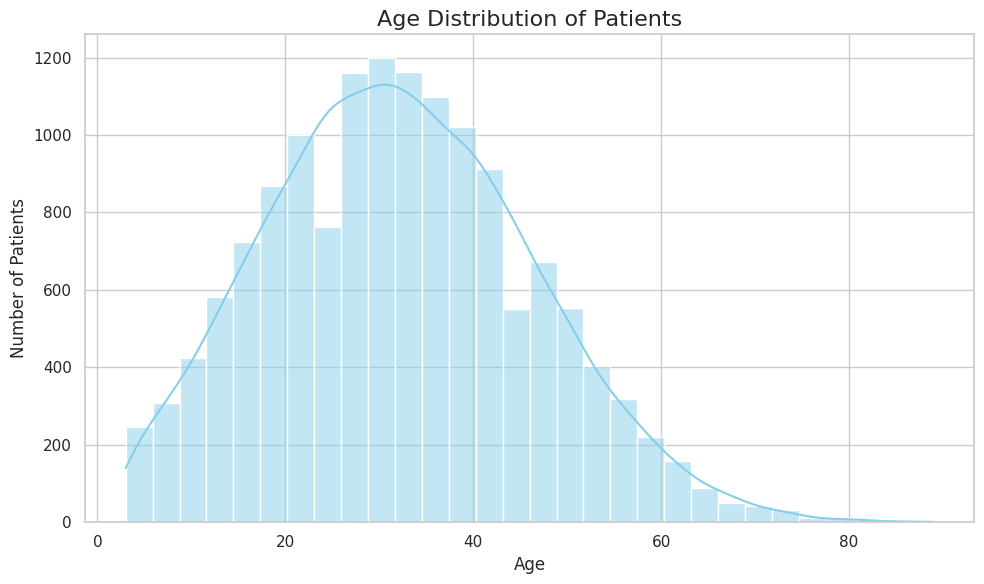

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution of Patients', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.tight_layout()
plt.show()


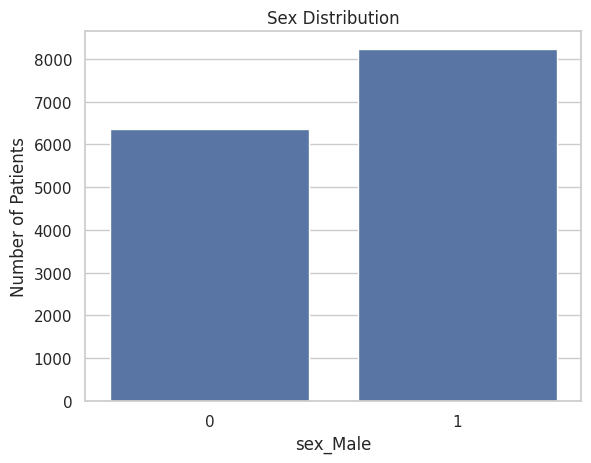

In [ ]:
sns.countplot(data=df, x='sex_Male')
plt.title("Sex Distribution")
plt.ylabel("Number of Patients")
plt.show()


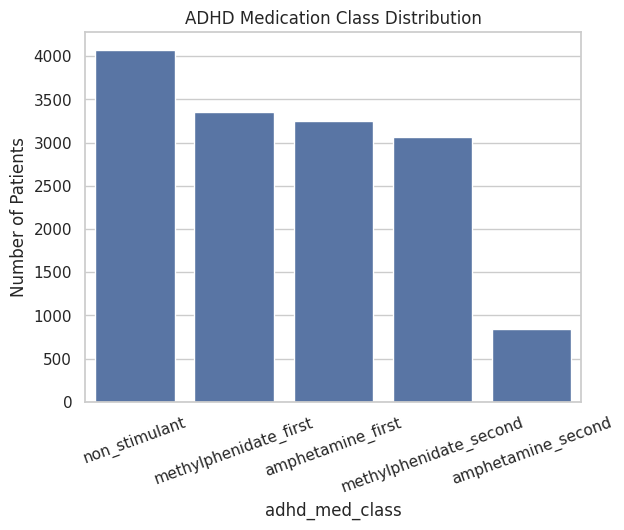

In [ ]:
sns.countplot(data=df, x='adhd_med_class', order=df['adhd_med_class'].value_counts().index)
plt.title("ADHD Medication Class Distribution")
plt.xticks(rotation=20)
plt.ylabel("Number of Patients")
plt.show()


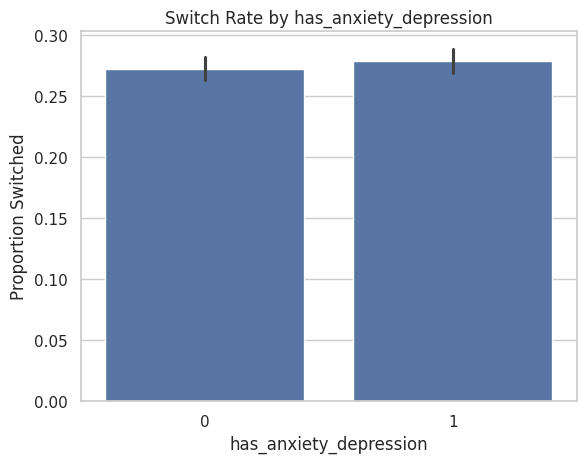

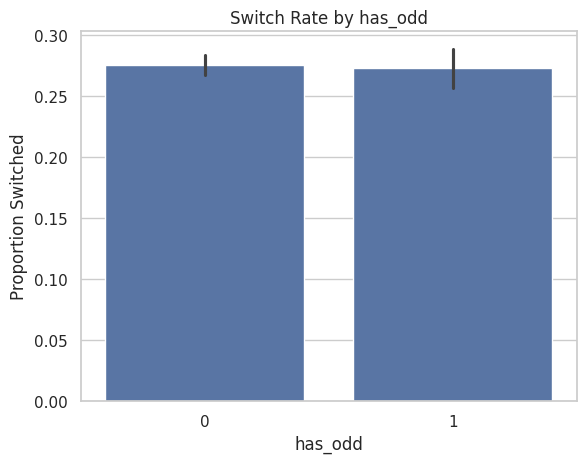

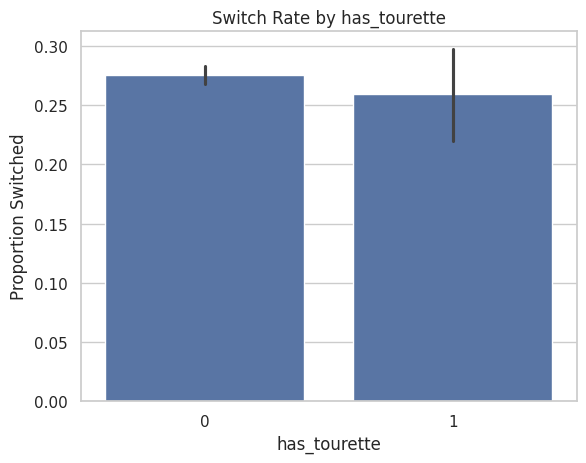

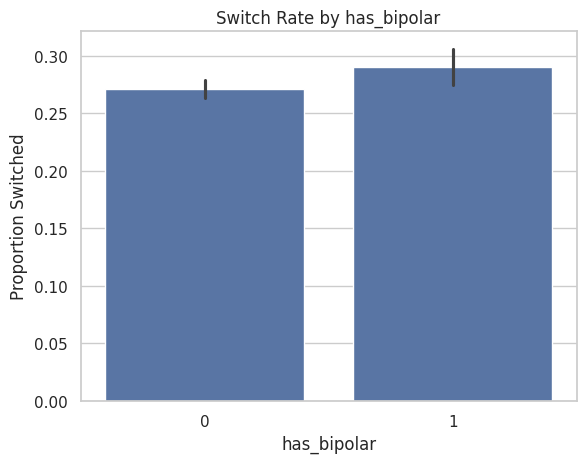

In [ ]:
comorbid_cols = ['has_anxiety_depression', 'has_odd', 'has_tourette', 'has_bipolar']
for col in comorbid_cols:
    sns.barplot(x=col, y='switched_med', data=df)
    plt.title(f"Switch Rate by {col}")
    plt.ylabel("Proportion Switched")
    plt.show()


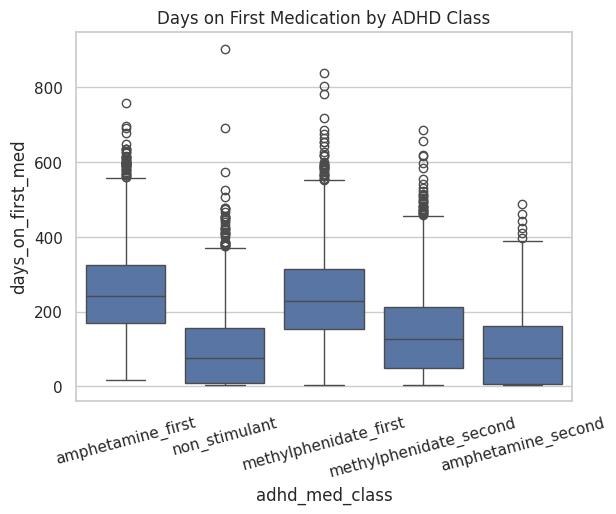

In [ ]:
sns.boxplot(data=df, x='adhd_med_class', y='days_on_first_med')
plt.title("Days on First Medication by ADHD Class")
plt.xticks(rotation=15)
plt.show()


In [ ]:
# Save the generated dataset
df.to_csv("UTopian_data.csv", index=False)

# Survival Models

1. Cox Proportional Hazards Model.

Is age associated with longer survival?

Do depression meds (like Fluvoxamine, Aripiprazole) increase duration?

In [ ]:
!pip install lifelines
from lifelines import CoxPHFitter

# Without SES - Confounding present here.

# Drop columns not needed for modeling
df_model = df.drop(columns=[
    'patient_id', 'postal_code', 'SES'
] + [col for col in df.columns if col in [
    'Lisdexamfetamine', 'Dexamfetamine', 'Vyvanse', 'Amphetamine', 'Adderall',
    'Dextroamphetamine', 'Dexedrine', 'Methylphenidate', 'Biphentin', 'Concerta',
    'FOQUEST', 'Ritalin', 'Atomoxetine', 'Strattera', 'Guanfacine', 'Intuniv'
]])

# Encoding categorical vars
df_model = pd.get_dummies(df_model, columns=['sex_Male', 'adhd_med_class'], drop_first=True)

# Fit Cox model
cph_confounding = CoxPHFitter()
cph_confounding.fit(df_model, duration_col='days_on_first_med', event_col='switched_med')
cph_confounding.print_summary()


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=ef9678f9218ffba18b7d5fd7febe3a114259bdc80c18fa9602bbe3f36fb7d005
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


<lifelines.CoxPHFitter: fitted with 14585 total observations, 10571 right-censored observations>
             duration col = 'days_on_first_med'
                event col = 'switched_med'
      baseline estimation = breslow
   number of observations = 14585
number of events observed = 4014
   partial log-likelihood = -33290.26
         time fit was run = 2025-08-29 15:13:29 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
age                                   -0.02      0.98      0.00           -0.03           -0.02                0.98                0.98
Ativan                                -0.04      0.96      0.06           -0.15            0.08                0.86                1.08
Clonazepam                             0.13      1.14      0.06            0.02            0.25                1.02                1.28
Fluoxetine                            -0.45      0.64      0.06           -0.57           -0.33                0.56                0.72
Sertraline                            -0.28      0.76      0.06           -0.39           -0.16                0.67                0.85
Citalopram                            -0.36      0.70      0.06           -0.48           -0.24                0.62                0.78
Escitalopram                          -0.16      0.85      0.06           -0.27           -0.05                0.76                0.96
Paroxetine                            -0.23      0.80      0.06           -0.35           -0.11                0.71                0.90
Fluvoxamine                           -0.36      0.70      0.06           -0.47           -0.24                0.62                0.79
Bupropion                             -0.05      0.95      0.06           -0.17            0.06                0.84                1.06
Venlafaxine                           -0.09      0.92      0.06           -0.20            0.03                0.82                1.03
Desvenlafaxine                        -0.17      0.84      0.06           -0.29           -0.05                0.75                0.95
Vortioxetine                           0.05      1.05      0.06           -0.06            0.17                0.94                1.18
Duloxetine                             0.05      1.05      0.06           -0.06            0.17                0.94                1.18
Vilazodone                            -0.08      0.92      0.06           -0.20            0.04                0.82                1.04
Intuniv XR                            -0.06      0.94      0.10           -0.26            0.13                0.77                1.14
Risperidone                            0.11      1.11      0.10           -0.09            0.30                0.92                1.35
Aripiprazole                          -0.51      0.60      0.10           -0.70           -0.33                0.50                0.72
Olanzapine                             0.04      1.05      0.10           -0.15            0.24                0.86                1.27
Quetiapine                            -0.08      0.93      0.10           -0.28            0.13                0.76                1.14
Ziprasidone                            0.07      1.07      0.10           -0.12            0.27                0.88                1.30
Paliperidone                          -0.17      0.85      0.10           -0.36            0.03                0.70                1.03
Clonidine                              0.33      1.39      0.52           -0.69            1.36                0.50                3.88
Guanfacine XR                          0.32      1.37      0.52           -0.70            1.33                0.50                3.80
Lithium                               -0.11      0.89      0.11           -0.3

In [ ]:
print('All numeric ✅' if df_model.select_dtypes(exclude='number').shape[1]==0 else f"Encode cols: {df_model.select_dtypes(exclude='number').columns.tolist()}")


Encode cols: ['sex_Male_1', 'adhd_med_class_amphetamine_second', 'adhd_med_class_methylphenidate_first', 'adhd_med_class_methylphenidate_second', 'adhd_med_class_non_stimulant']


In [ ]:
# With SES - No Confounding
df_model = df.drop(columns=[ 'patient_id','postal_code',
] + [c for c in df.columns if c in [
    'Lisdexamfetamine','Dexamfetamine','Vyvanse','Amphetamine','Adderall',
    'Dextroamphetamine','Dexedrine','Methylphenidate','Biphentin','Concerta',
    'FOQUEST','Ritalin','Atomoxetine','Strattera','Guanfacine','Intuniv'
]])

#one-hot encode ONLY 'adhd_med_class' and 'SES'
df_model = pd.get_dummies(df_model, columns=['adhd_med_class','SES'], drop_first=True)

# 3force everything numeric
df_model = df_model.astype(float)


# Fit Cox model
cph_no_confounding = CoxPHFitter()
cph_no_confounding.fit(df_model, duration_col='days_on_first_med', event_col='switched_med')
cph_no_confounding.print_summary()


<lifelines.CoxPHFitter: fitted with 14585 total observations, 10571 right-censored observations>
             duration col = 'days_on_first_med'
                event col = 'switched_med'
      baseline estimation = breslow
   number of observations = 14585
number of events observed = 4014
   partial log-likelihood = -32872.51
         time fit was run = 2025-08-29 15:13:30 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
age                                   -0.03      0.98      0.00           -0.03           -0.02                0.97                0.98
Ativan                                -0.03      0.97      0.06           -0.14            0.08                0.87                1.09
Clonazepam                             0.13      1.14      0.06            0.02            0.25                1.02                1.28
Fluoxetine                            -0.46      0.63      0.06           -0.59           -0.34                0.56                0.71
Sertraline                            -0.32      0.73      0.06           -0.43           -0.20                0.65                0.82
Citalopram                            -0.41      0.67      0.06           -0.53           -0.29                0.59                0.75
Escitalopram                          -0.22      0.80      0.06           -0.34           -0.11                0.71                0.90
Paroxetine                            -0.23      0.79      0.06           -0.35           -0.11                0.70                0.89
Fluvoxamine                           -0.35      0.70      0.06           -0.47           -0.23                0.63                0.79
Bupropion                             -0.07      0.93      0.06           -0.18            0.04                0.83                1.05
Venlafaxine                           -0.08      0.93      0.06           -0.19            0.04                0.82                1.04
Desvenlafaxine                        -0.18      0.83      0.06           -0.30           -0.06                0.74                0.94
Vortioxetine                           0.07      1.08      0.06           -0.04            0.19                0.96                1.21
Duloxetine                             0.08      1.08      0.06           -0.03            0.19                0.97                1.21
Vilazodone                            -0.05      0.95      0.06           -0.17            0.07                0.84                1.07
Intuniv XR                            -0.14      0.87      0.10           -0.34            0.05                0.71                1.05
Risperidone                            0.07      1.08      0.10           -0.12            0.27                0.88                1.31
Aripiprazole                          -0.64      0.53      0.10           -0.83           -0.45                0.44                0.64
Olanzapine                             0.04      1.04      0.10           -0.15            0.23                0.86                1.26
Quetiapine                            -0.05      0.95      0.11           -0.25            0.16                0.78                1.17
Ziprasidone                            0.03      1.03      0.10           -0.16            0.23                0.85                1.25
Paliperidone                          -0.22      0.80      0.10           -0.42           -0.03                0.66                0.97
Clonidine                              0.25      1.29      0.52           -0.77            1.28                0.46                3.60
Guanfacine XR                          0.27      1.31      0.52           -0.75            1.29                0.47                3.62
Lithium                               -0.08      0.92      0.11           -0.2

**CoxPH Model without SES (unadjusted)**

Concordance: 0.76 (↓ predictive performance)

Med class effects blown up:

amphetamine_second HR 4.98 (vs 1.19 adjusted)

methylphenidate_second HR 2.43 (vs 1.13 adjusted)

non_stimulant HR 3.98 (vs 1.75 adjusted)

sex_Male HR 2.11 (vs 2.36 adjusted — small change)

Age slightly closer to null (-0.02 vs -0.03)



**CoxPH Model with SES (adjusted)**



Concordance: 0.80 (+0.04)

SES_Low HR 7.59, SES_Medium HR 2.60 — huge and significant

Med class HRs drop to more plausible range

Confounding explained: high-SES vs low-SES differences were artificially boosting med-class hazard ratios in unadjusted model

# SHAP and PDP for CoxPH model


Unadjusted (omit SES) — Test C-index: 0.758


Adjusted (include SES) — Test C-index: 0.806


  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipython-input-3588616127.py:122: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, Xs, show=False)


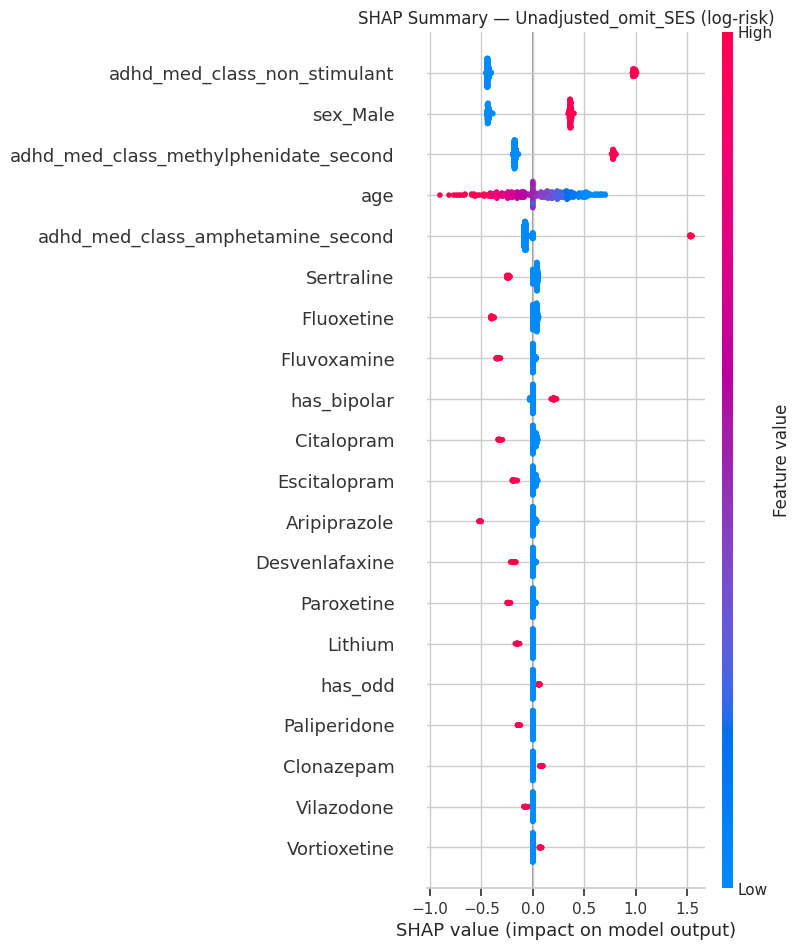

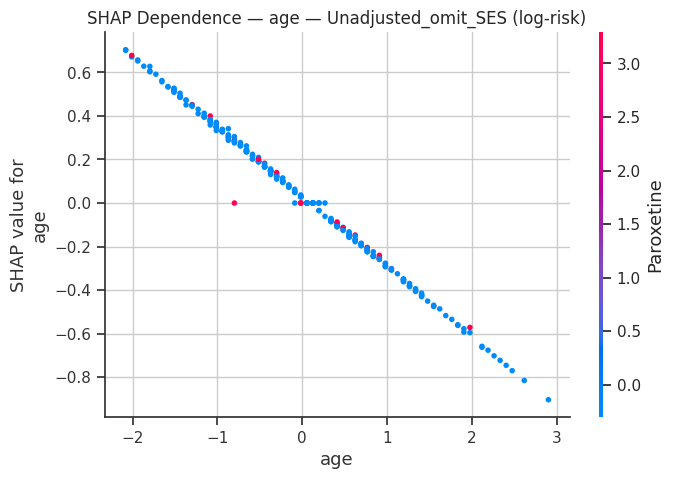

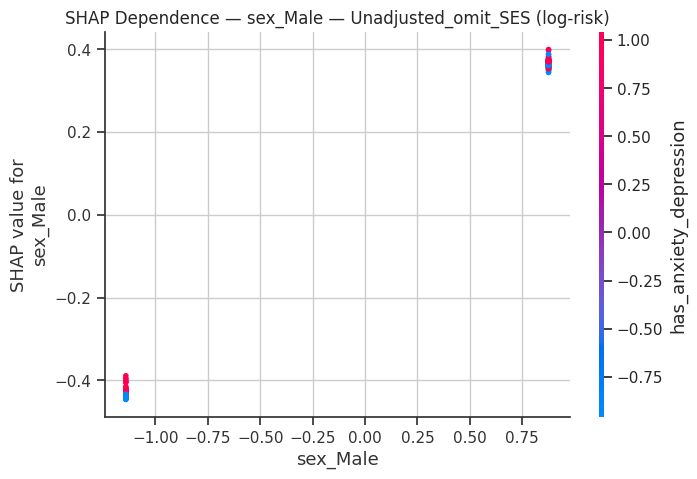

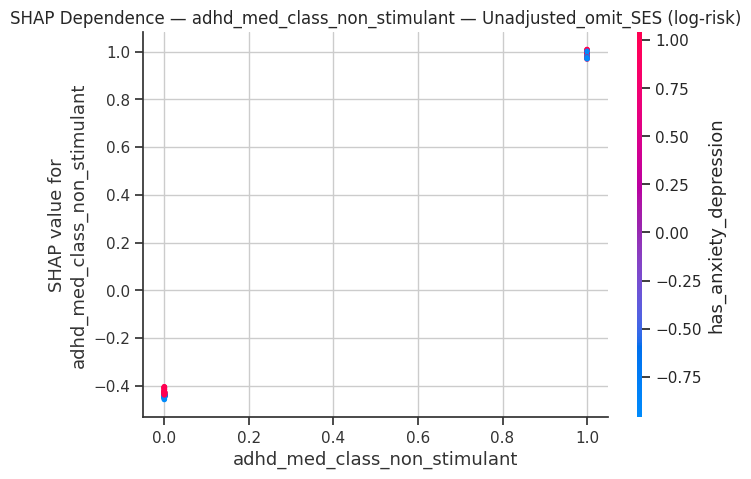

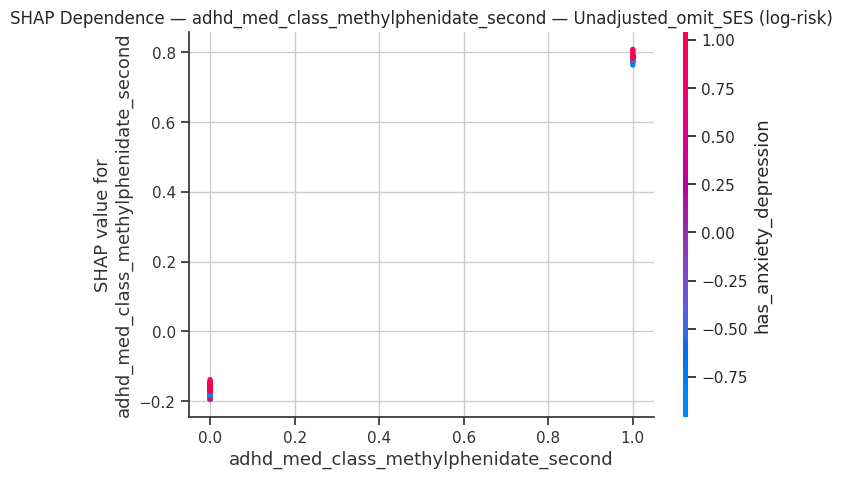

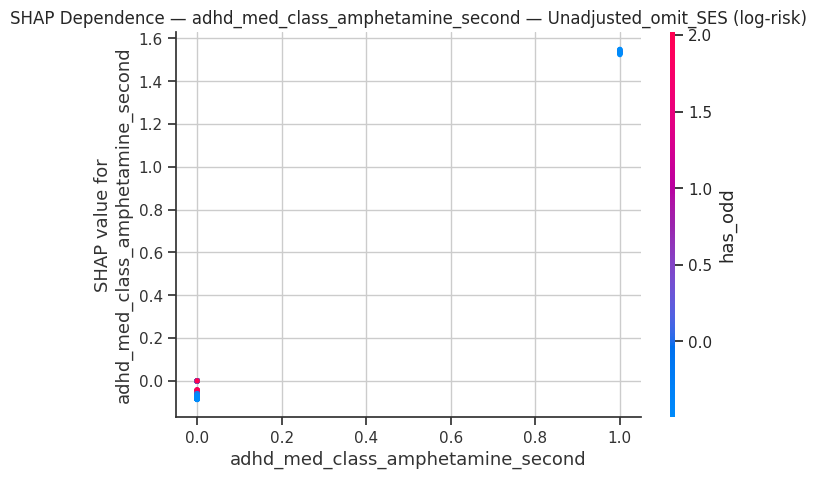

  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipython-input-3588616127.py:122: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, Xs, show=False)


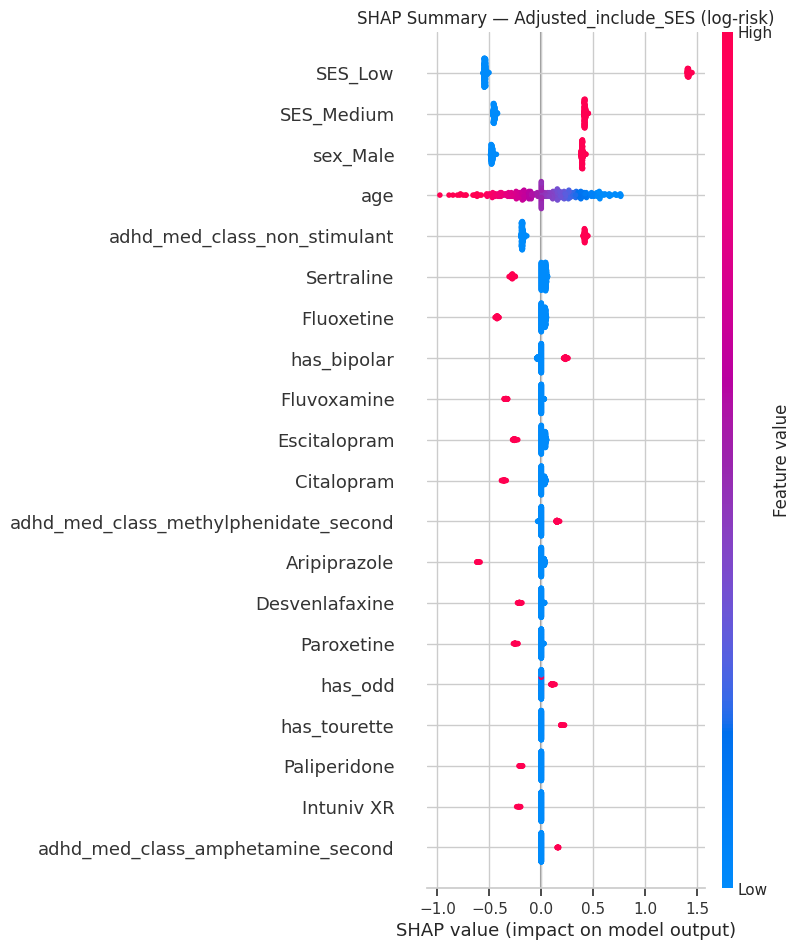

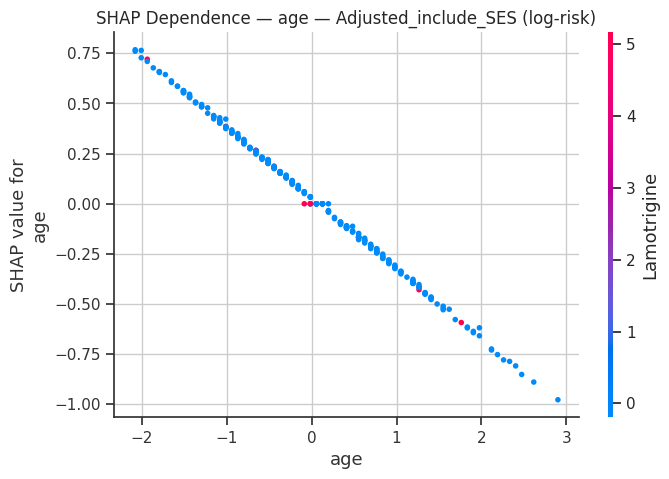

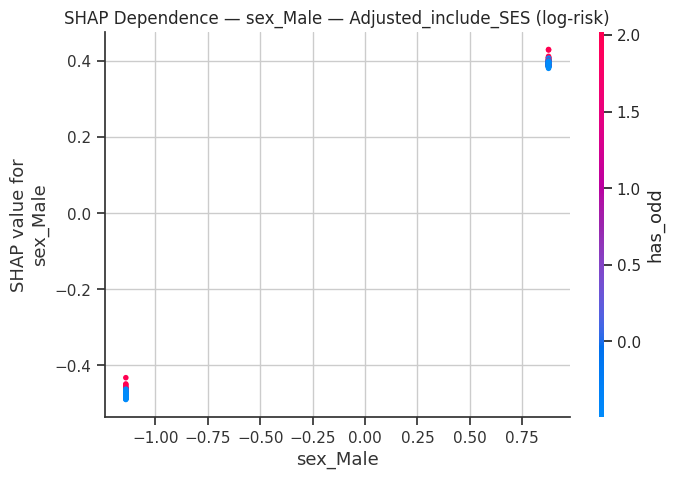

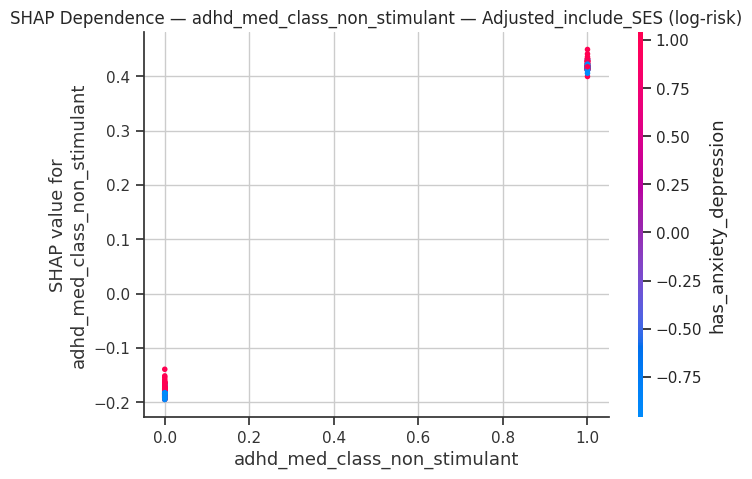

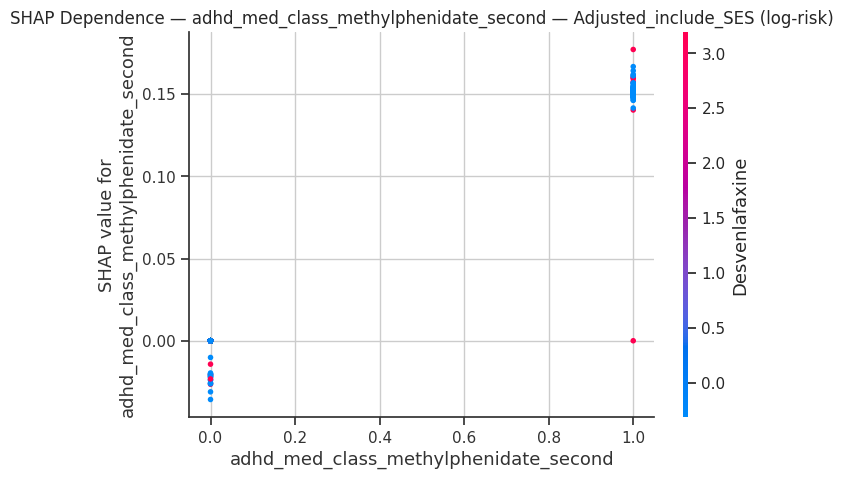

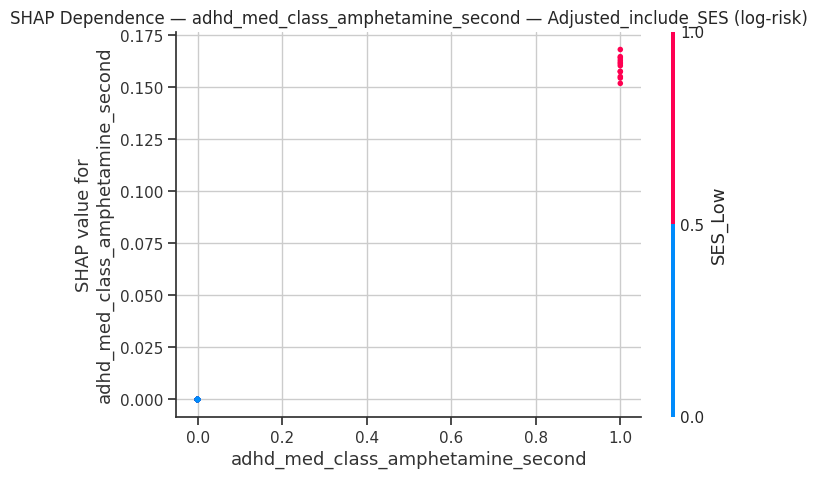

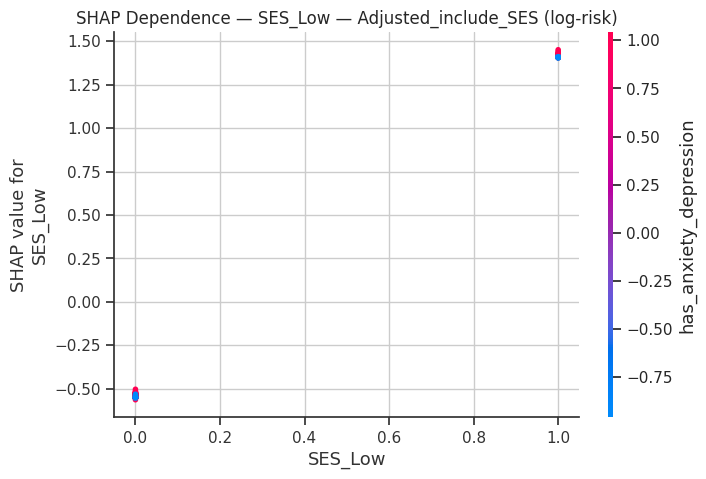

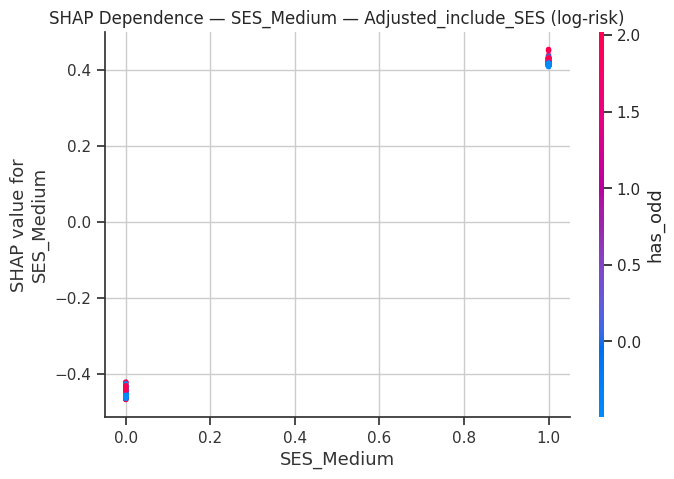

In [42]:
# ============================================
# CoxPH (Unadjusted vs Adjusted for SES) + SHAP
# Clean version — NO PDP, SHAP on log-risk
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

SEED = 42
rng = np.random.default_rng(SEED)

# ---------- Build design matrices (optionally include SES as a feature)
def build_matrices(df: pd.DataFrame, include_ses: bool):
    drop_cols = ['patient_id', 'postal_code']
    med_first_cols = [
        'Lisdexamfetamine','Dexamfetamine','Vyvanse','Amphetamine','Adderall',
        'Dextroamphetamine','Dexedrine','Methylphenidate','Biphentin','Concerta',
        'FOQUEST','Ritalin','Atomoxetine','Strattera','Guanfacine','Intuniv'
    ]
    drop_cols += [c for c in df.columns if c in med_first_cols]
    data = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore").copy()

    # Targets
    y_time  = data['days_on_first_med'].to_numpy()
    y_event = data['switched_med'].to_numpy().astype(int)

    # Features
    X = data.drop(columns=['days_on_first_med', 'switched_med'])
    # Explicitly drop SES dummies if running unadjusted
    if not include_ses:
      X = X.drop(columns=[c for c in X.columns if c.startswith("SES")], errors="ignore")


    # Decide categorical columns
    cat_cols = []
    if 'sex' in X.columns and X['sex'].dtype == 'O':
        cat_cols.append('sex')
    if 'adhd_med_class' in X.columns and X['adhd_med_class'].dtype == 'O':
        cat_cols.append('adhd_med_class')
    if include_ses and ('SES' in X.columns) and (X['SES'].dtype == 'O'):
        cat_cols.append('SES')
    # Any other object columns -> categorical
    for c in X.select_dtypes(include='object').columns:
        if c not in cat_cols:
            cat_cols.append(c)

    num_cols = [c for c in X.columns if c not in cat_cols]

    # Preprocess: scale numeric, OHE categorical
    try:
        ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", ohe, cat_cols),
        ],
        remainder="drop",
    )

    X_tr, X_te, t_tr, t_te, e_tr, e_te = train_test_split(
        X, y_time, y_event, test_size=0.2, random_state=SEED, shuffle=True
    )

    X_tr_t = pre.fit_transform(X_tr)
    X_te_t = pre.transform(X_te)

    # Recover feature names
    feat_names = []
    if num_cols:
        feat_names += num_cols
    if cat_cols:
        feat_names += pre.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist()

    Xtr_df = pd.DataFrame(X_tr_t, columns=feat_names)
    Xte_df = pd.DataFrame(X_te_t, columns=feat_names)

    # lifelines wants duration/event columns inside the frame
    train_df = Xtr_df.copy(); train_df['days_on_first_med'] = t_tr; train_df['switched_med'] = e_tr
    test_df  = Xte_df.copy(); test_df['days_on_first_med']  = t_te; test_df['switched_med']  = e_te

    return train_df, test_df, feat_names

# ---------- Fit CoxPH and evaluate C-index on test
def fit_and_eval(train_df: pd.DataFrame, test_df: pd.DataFrame):
    cph = CoxPHFitter()
    cph.fit(train_df, duration_col='days_on_first_med', event_col='switched_med')
    risk_test = cph.predict_partial_hazard(test_df).values.ravel()
    cidx_test = concordance_index(test_df['days_on_first_med'].values, -risk_test, test_df['switched_med'].values)
    return cph, cidx_test

# ---------- SHAP via KernelExplainer on log-risk (additive scale)
def shap_kernel_on_cox_logrisk(cph: CoxPHFitter, X_train_df: pd.DataFrame, X_test_df: pd.DataFrame,
                               nsamp_bg=150, nsamp_test=300, tag=""):
    # background set
    bg = X_train_df.sample(min(len(X_train_df), nsamp_bg), random_state=SEED)

    def predict_logrisk(X):
        dfp = pd.DataFrame(X, columns=X_train_df.columns).copy()
        # lifelines ignores these, but padding keeps shapes consistent
        dfp['days_on_first_med'] = 0.0
        dfp['switched_med'] = 0
        # log partial hazard
        ph = cph.predict_partial_hazard(dfp).values.ravel()
        return np.log(ph + 1e-12)

    explainer = shap.KernelExplainer(predict_logrisk, bg.values)
    Xs = X_test_df.sample(min(len(X_test_df), nsamp_test), random_state=SEED)
    shap_vals = explainer.shap_values(Xs.values, nsamples="auto")

    # Summary (beeswarm-style) using legacy summary_plot
    shap.summary_plot(shap_vals, Xs, show=False)
    plt.title(f"SHAP Summary — {tag} (log-risk)")
    plt.savefig(f"shap_summary_{tag}_logrisk.png", dpi=150, bbox_inches="tight")
    plt.show()

    return Xs, shap_vals

def shap_dependence_set(shap_vals, Xs: pd.DataFrame, features: list, tag: str):
    for f in features:
        if f in Xs.columns:
            shap.dependence_plot(f, shap_vals, Xs, show=False)
            plt.title(f"SHAP Dependence — {f} — {tag} (log-risk)")
            plt.savefig(f"shap_dep_{f}_{tag}_logrisk.png", dpi=150, bbox_inches="tight")
            plt.show()

# ===========================
# RUN: Unadjusted (omit SES) vs Adjusted (include SES)
# ===========================
# Unadjusted (confounding present: SES omitted from features)
train_u, test_u, feats_u = build_matrices(df, include_ses=False)
cph_u, cidx_u = fit_and_eval(train_u, test_u)
print(f"Unadjusted (omit SES) — Test C-index: {cidx_u:.3f}")

# Adjusted (confounding controlled: SES included as features)
train_a, test_a, feats_a = build_matrices(df, include_ses=True)
cph_a, cidx_a = fit_and_eval(train_a, test_a)
print(f"Adjusted (include SES) — Test C-index: {cidx_a:.3f}")

# ===========================
# SHAP — summary + dependence (log-risk)
# ===========================
# Unadjusted
Xs_u, shap_u = shap_kernel_on_cox_logrisk(
    cph_u,
    train_u.drop(columns=['days_on_first_med','switched_med']),
    test_u.drop(columns=['days_on_first_med','switched_med']),
    tag="Unadjusted_omit_SES"
)
cand_u = [
    'age',
    'sex_Male', 'sex_Male_1',  # whichever exists
    'adhd_med_class_non_stimulant',
    'adhd_med_class_methylphenidate_second',
    'adhd_med_class_amphetamine_second'
]
shap_dependence_set(shap_u, Xs_u, cand_u, tag="Unadjusted_omit_SES")

# Adjusted
Xs_a, shap_a = shap_kernel_on_cox_logrisk(
    cph_a,
    train_a.drop(columns=['days_on_first_med','switched_med']),
    test_a.drop(columns=['days_on_first_med','switched_med']),
    tag="Adjusted_include_SES"
)
cand_a = cand_u + ['SES_Low', 'SES_Medium']  # present only when SES is included
shap_dependence_set(shap_a, Xs_a, cand_a, tag="Adjusted_include_SES")


nterpretation of CoxPH SHAP Plots

1. Unadjusted (omit SES) — Left plot

SES variables are absent (as expected).

Top drivers:

ADHD med classes (non_stimulant, methylphenidate_second, amphetamine_second) have clear contributions.

Sex_Male strongly increases risk (positive SHAP values).

Age shows mixed effects but still relevant.

Some antidepressants (Sertraline, Fluoxetine, Fluvoxamine) also influence predictions, though effects are smaller.

Because SES is missing, other features (e.g., sex, med classes) might pick up spurious associations (confounding).

2. Adjusted (include SES) — Right plot

SES_Low and SES_Medium appear at the top, with large SHAP values → socioeconomic status is a strong confounder.

Once SES is included, some medication effects shrink in importance compared to unadjusted.

Sex_Male remains important, but its SHAP magnitude is slightly reduced compared to the unadjusted model.

Overall, the model is more interpretable and aligned with reality — SES captures much of the systematic variation.

# Deep Survival Model- with PyCox

Neural net to model non-linear & interactive effects

Compare to Cox (via concordance index)

Interpret via SHAP or permutation importance

**Just Notes**

pycox is a python package for survival analysis and time-to-event prediction with PyTorch. It is built on the torchtuples package for training PyTorch models.

Read the documentation at: https://github.com/havakv/pycox

The package contains

survival models: (Logistic-Hazard, DeepHit, DeepSurv, Cox-Time, MTLR, etc.)
evaluation criteria (concordance, Brier score, Binomial log-likelihood, etc.)
event-time datasets (SUPPORT, METABRIC, KKBox, etc)
simulation studies
illustrative examples

In [ ]:
!pip install pycox torchtuples scikit-learn pandas lifelines --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.6/413.6 kB 26.9 MB/s eta 0:00:00


In [40]:
# =============================
# DeepSurv (pycox) — Omit SES vs Include SES
# Clean, no leakage, consistent splits
# =============================
import numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import torchtuples as tt

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---------- Load base frame (no feature dropping yet)
df0 = pd.read_csv("UTopian_data.csv")

# columns you NEVER feed as features (IDs, geo, raw med columns, optional flags)
ALWAYS_DROP = [
    'patient_id','postal_code',
    'Lisdexamfetamine','Dexamfetamine','Vyvanse','Amphetamine','Adderall',
    'Dextroamphetamine','Dexedrine','Methylphenidate','Biphentin','Concerta',
    'FOQUEST','Ritalin','Atomoxetine','Strattera','Guanfacine','Intuniv',
    # if these flags are engineered elsewhere and you don't want them in DeepSurv, keep them dropped:
    # otherwise remove them from this list to include them
    'has_anxiety_depression','has_odd','has_tourette','has_bipolar'
]
TARGET_TIME  = 'days_on_first_med'
TARGET_EVENT = 'switched_med'

def build_xy(df_in: pd.DataFrame, include_ses: bool):
    """Returns X_train, X_val, y_train(time,event), y_val(time,event), and fitted scaler/column names."""
    df = df_in.drop(columns=[c for c in ALWAYS_DROP if c in df_in.columns], errors="ignore").copy()
    if not include_ses and "SES" in df.columns:
      df = df.drop(columns=["SES"])

    # Ensure targets are present
    assert TARGET_TIME in df.columns and TARGET_EVENT in df.columns, "Missing targets in dataframe."

    # Decide which columns to one-hot
    cat_cols = []
    # If you have text 'sex', one-hot it; if you already have numeric 'sex_Male' 0/1, leave it numeric.
    if 'sex' in df.columns and df['sex'].dtype == 'O':
        cat_cols.append('sex')
    if 'adhd_med_class' in df.columns and df['adhd_med_class'].dtype == 'O':
        cat_cols.append('adhd_med_class')
    if include_ses and ('SES' in df.columns) and (df['SES'].dtype == 'O'):
        cat_cols.append('SES')

    # Treat any other object columns as categorical too (safety)
    for c in df.select_dtypes(include='object').columns:
        if c not in cat_cols:
            cat_cols.append(c)

    # Split targets / features
    y_time  = df[TARGET_TIME].to_numpy().astype(np.float32)
    y_event = df[TARGET_EVENT].to_numpy().astype(np.float32)
    X = df.drop(columns=[TARGET_TIME, TARGET_EVENT]).copy()

    # Build preprocessor (scale numeric, OHE categoricals)
    num_cols = [c for c in X.columns if c not in cat_cols]
    try:
        ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
    except TypeError:  # older sklearn
        ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", ohe, cat_cols),
        ],
        remainder="drop",
    )

    # Train/val split BEFORE fitting the scaler to avoid leakage
    X_tr, X_val, t_tr, t_val, e_tr, e_val = train_test_split(
        X, y_time, y_event, test_size=0.2, random_state=SEED, shuffle=True
    )

    X_tr_t = pre.fit_transform(X_tr)
    X_val_t = pre.transform(X_val)

    # Recover feature names for reference
    feat_names = []
    if num_cols: feat_names += num_cols
    if cat_cols: feat_names += pre.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist()

    # Tensors
    x_tr_tensor = torch.tensor(X_tr_t, dtype=torch.float32)
    x_val_tensor = torch.tensor(X_val_t, dtype=torch.float32)
    y_tr_tuple = (torch.tensor(t_tr, dtype=torch.float32),
                  torch.tensor(e_tr, dtype=torch.float32))
    y_val_tuple = (torch.tensor(t_val, dtype=torch.float32),
                   torch.tensor(e_val, dtype=torch.float32))
    return x_tr_tensor, x_val_tensor, y_tr_tuple, y_val_tuple, feat_names

def train_deepsurv(x_tr, y_tr, x_val, y_val, input_dim, lr=1e-3, epochs=100, batch_size=256):
    net = torch.nn.Sequential(
        torch.nn.Linear(input_dim, 64),
        torch.nn.ReLU(),
        torch.nn.BatchNorm1d(64),
        torch.nn.Dropout(0.3),
        torch.nn.Linear(64, 32),
        torch.nn.ReLU(),
        torch.nn.BatchNorm1d(32),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(32, 1),
    )
    model = CoxPH(net, tt.optim.Adam)
    model.optimizer.set_lr(lr)

    # Optional: callbacks (early stopping) to prevent overfitting
    # cb = [tt.callbacks.EarlyStopping(patience=10)]
    # log = model.fit(x_tr, y_tr, batch_size=batch_size, epochs=epochs, val_data=(x_val, y_val), callbacks=cb, verbose=True)

    log = model.fit(x_tr, y_tr, batch_size=batch_size, epochs=epochs, val_data=(x_val, y_val), verbose=True)
    model.compute_baseline_hazards()  # needed before predict_surv_df
    return model

def eval_cindex(model: CoxPH, x_val, y_val):
    # pycox returns survival curves; EvalSurv expects times/events as numpy arrays
    surv_df = model.predict_surv_df(x_val)  # index: durations; columns: individuals
    ev = EvalSurv(surv_df, y_val[0].numpy(), y_val[1].numpy(), censor_surv='km')
    return ev.concordance_td('antolini')

# ------------------------
# Experiment A: UNADJUSTED (omit SES)
# ------------------------
xtr_u, xva_u, ytr_u, yva_u, feats_u = build_xy(df0, include_ses=False)
model_u = train_deepsurv(xtr_u, ytr_u, xva_u, yva_u, input_dim=xtr_u.shape[1])
cidx_u = eval_cindex(model_u, xva_u, yva_u)
print(f"[DeepSurv] Unadjusted (omit SES) — C-index: {cidx_u:.3f}")

# ------------------------
# Experiment B: ADJUSTED (include SES)
# ------------------------
xtr_a, xva_a, ytr_a, yva_a, feats_a = build_xy(df0, include_ses=True)
model_a = train_deepsurv(xtr_a, ytr_a, xva_a, yva_a, input_dim=xtr_a.shape[1])
cidx_a = eval_cindex(model_a, xva_a, yva_a)
print(f"[DeepSurv] Adjusted (include SES) — C-index: {cidx_a:.3f}")


0:	[0s / 0s],		train_loss: 4.5317,	val_loss: 6.8614
1:	[0s / 0s],		train_loss: 4.4235,	val_loss: 6.8298
2:	[0s / 0s],		train_loss: 4.3866,	val_loss: 6.8145
3:	[0s / 0s],		train_loss: 4.3463,	val_loss: 6.8003
4:	[0s / 0s],		train_loss: 4.3148,	val_loss: 6.7955
5:	[0s / 1s],		train_loss: 4.3138,	val_loss: 6.7818
6:	[0s / 1s],		train_loss: 4.2924,	val_loss: 6.7695
7:	[0s / 1s],		train_loss: 4.2767,	val_loss: 6.7608
8:	[0s / 1s],		train_loss: 4.2609,	val_loss: 6.7569
9:	[0s / 1s],		train_loss: 4.2617,	val_loss: 6.7465
10:	[0s / 1s],		train_loss: 4.2314,	val_loss: 6.7461
11:	[0s / 2s],		train_loss: 4.2374,	val_loss: 6.7481
12:	[0s / 2s],		train_loss: 4.2293,	val_loss: 6.7358
13:	[0s / 2s],		train_loss: 4.2242,	val_loss: 6.7405
14:	[0s / 2s],		train_loss: 4.2132,	val_loss: 6.7362
15:	[0s / 2s],		train_loss: 4.2099,	val_loss: 6.7344
16:	[0s / 3s],		train_loss: 4.2046,	val_loss: 6.7380
17:	[0s / 3s],		train_loss: 4.2001,	val_loss: 6.7375
18:	[0s / 3s],		train_loss: 4.1994,	val_loss: 6.7289
19:

  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipython-input-282398529.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, Xs, show=False)


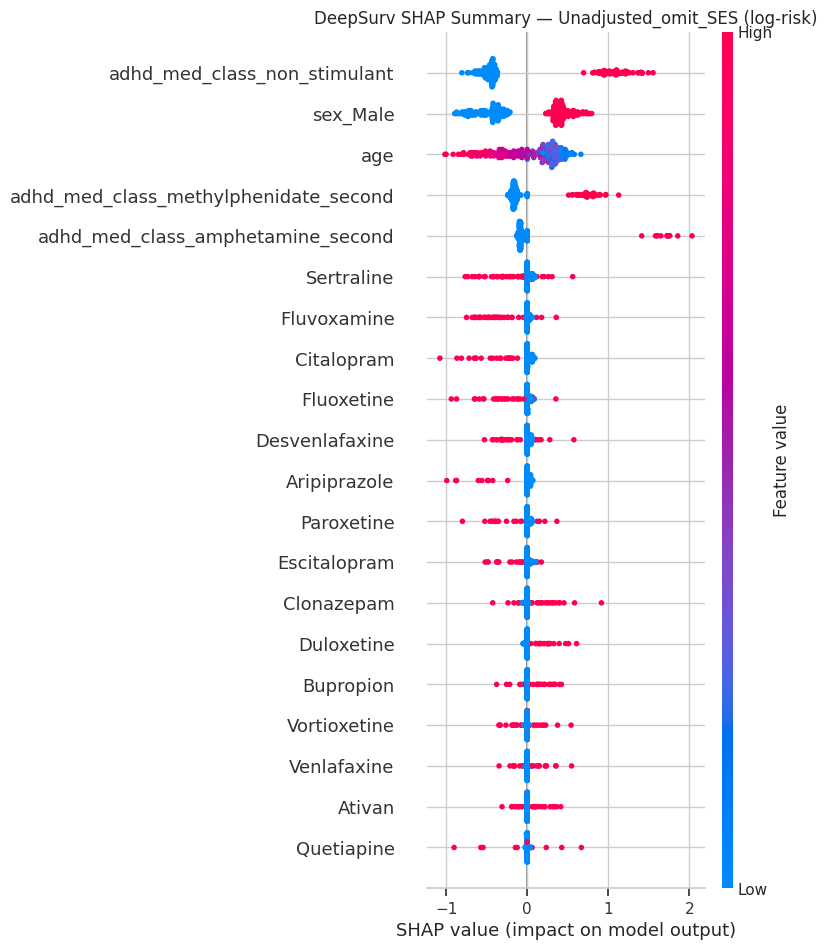

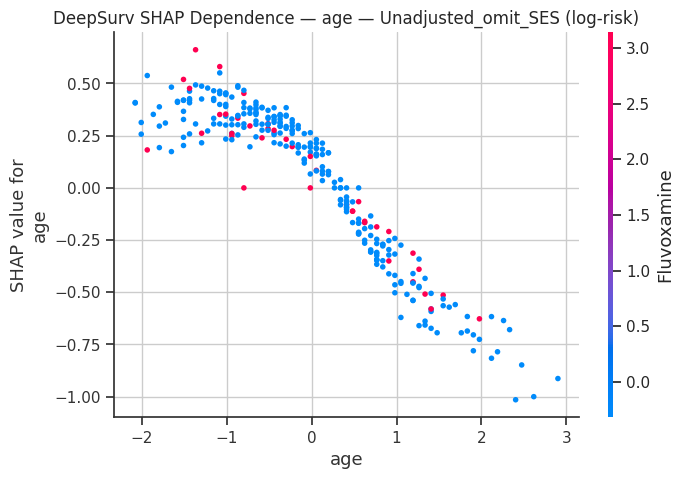

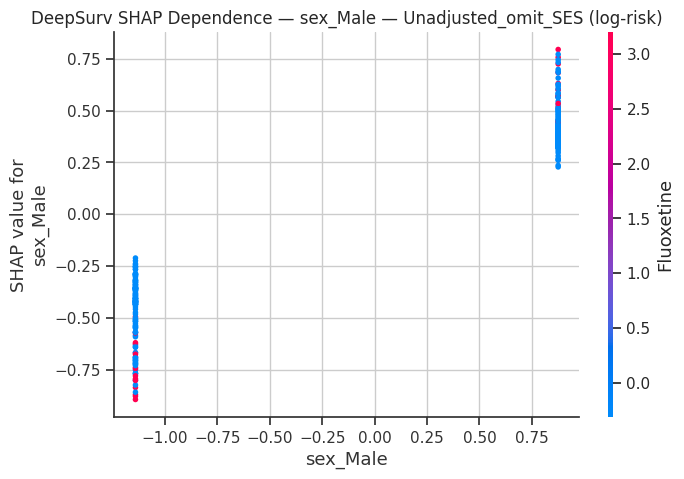

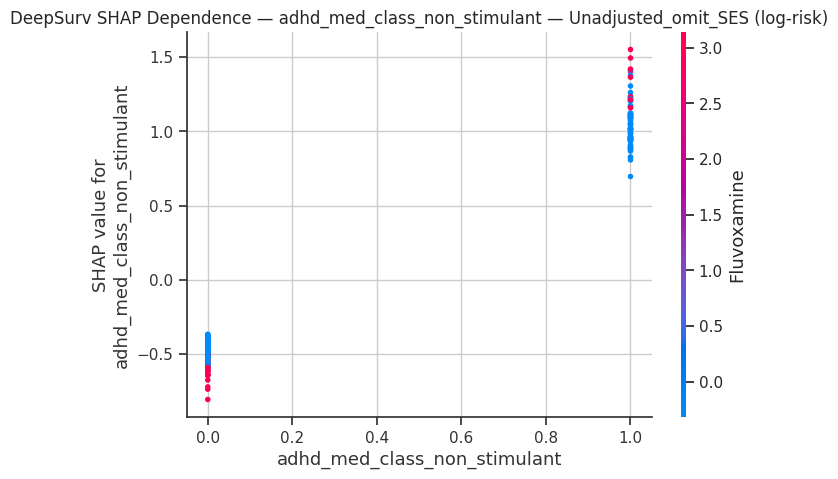

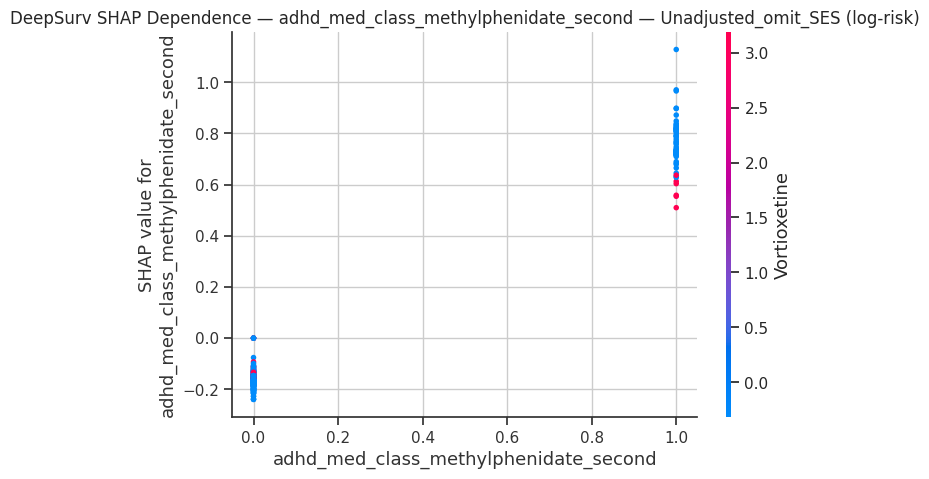

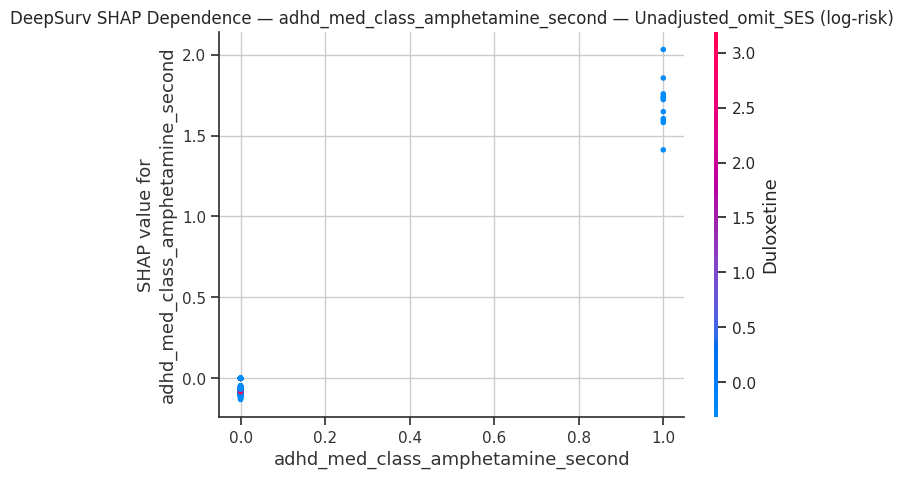

  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipython-input-282398529.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, Xs, show=False)


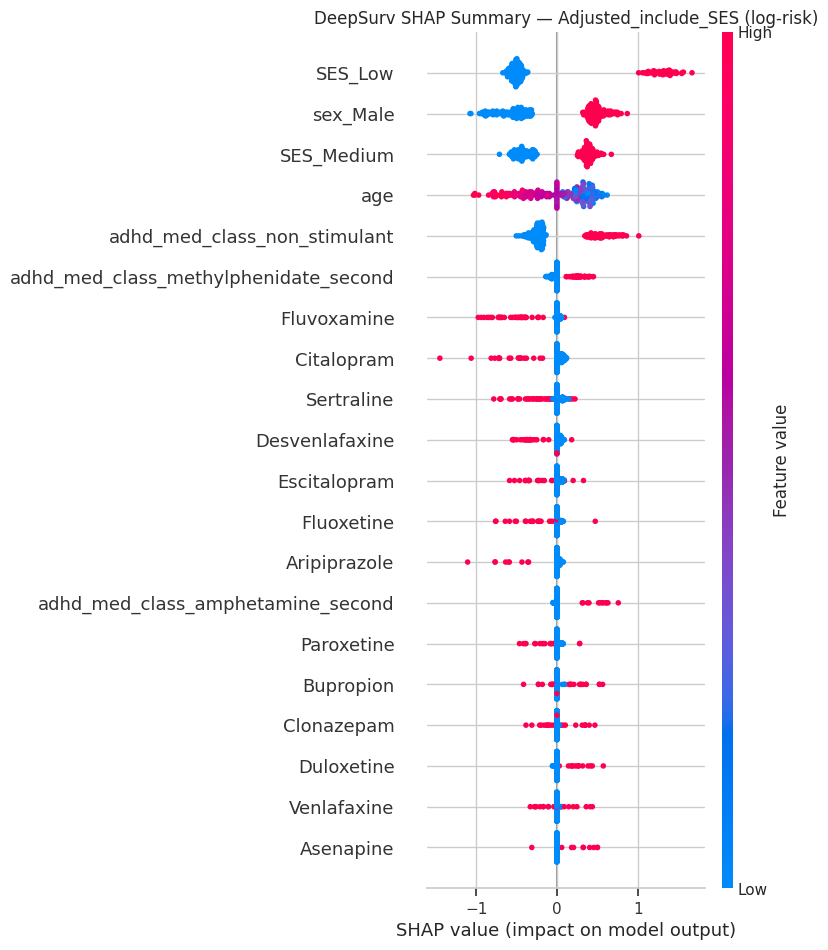

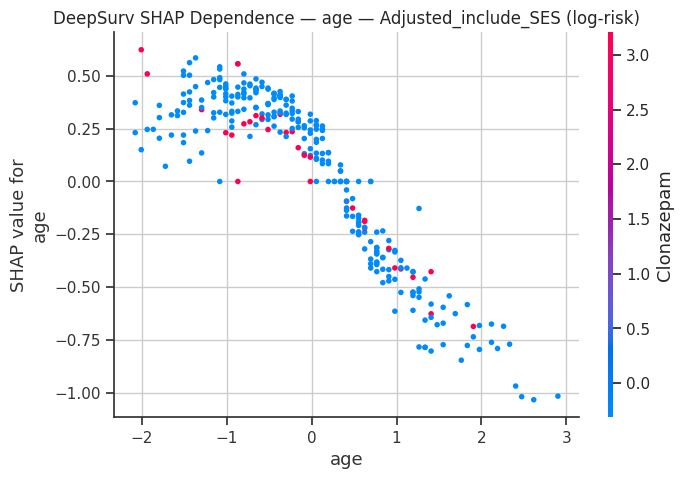

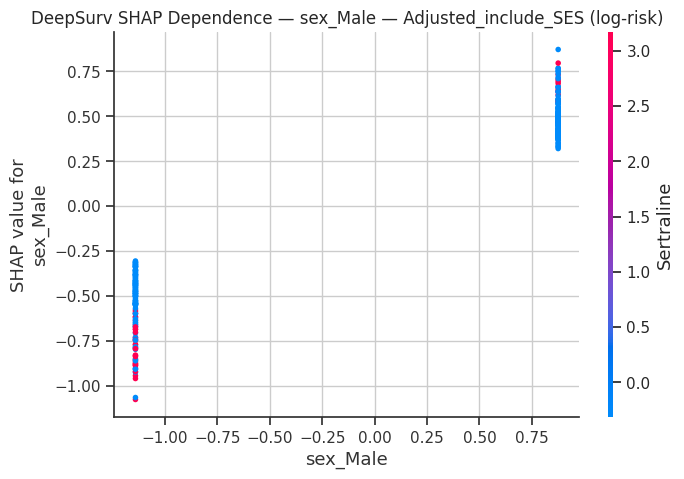

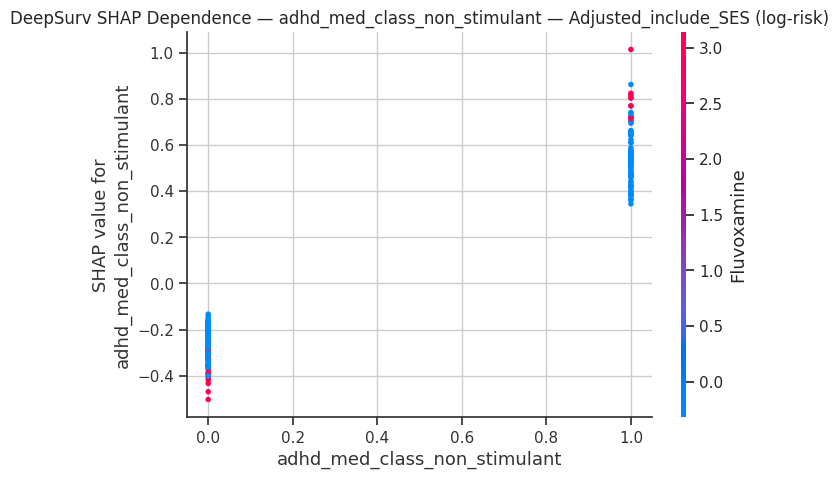

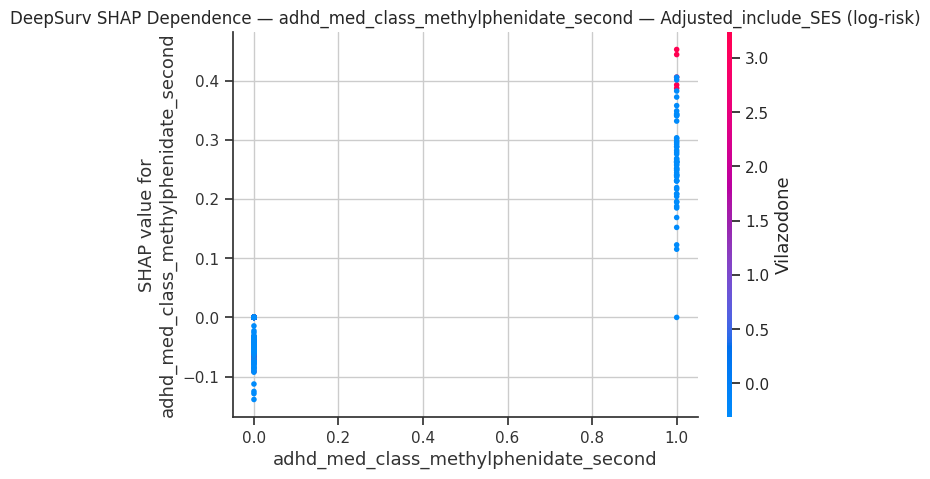

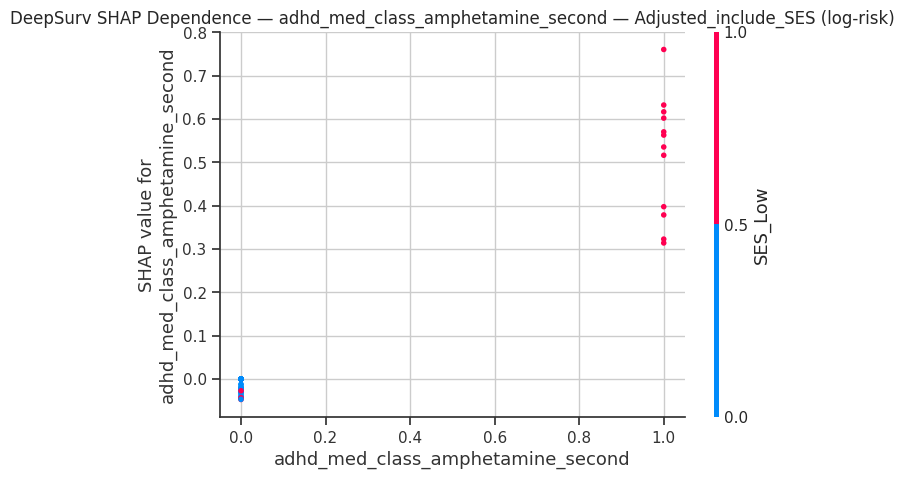

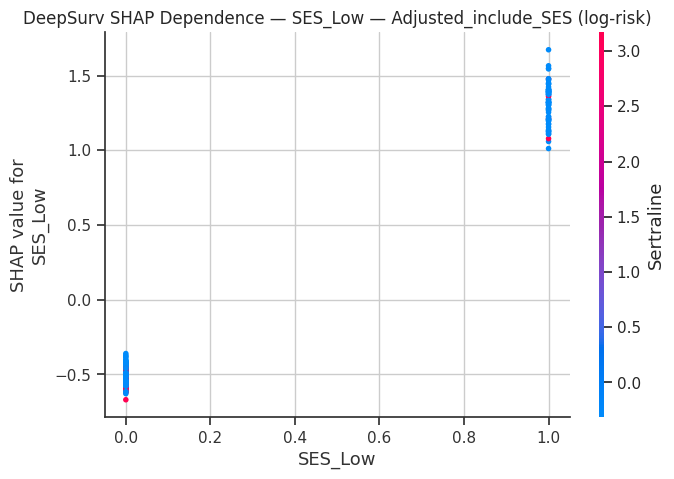

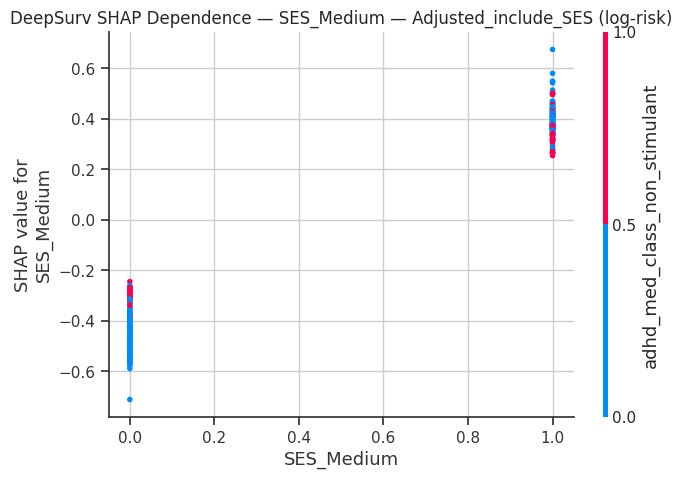

In [41]:
# =============================
# SHAP for DeepSurv (log-risk) — Unadjusted vs Adjusted
# =============================

def shap_deepsurv_logrisk(model, Xtr_tensor, Xval_tensor, feat_names, tag,
                          nsamp_bg=150, nsamp_val=300):
    # to DataFrames with column names for pretty plots
    Xtr_df = pd.DataFrame(Xtr_tensor.numpy(), columns=feat_names)
    Xval_df = pd.DataFrame(Xval_tensor.numpy(), columns=feat_names)

    # prediction function: DeepSurv returns a 1-D risk score ~ log-risk
    def f(X):
        with torch.no_grad():
            xt = torch.tensor(X, dtype=torch.float32)
            pred = model.predict(xt).reshape(-1).numpy()
        return pred

    # background + sample
    bg = Xtr_df.sample(min(len(Xtr_df), nsamp_bg), random_state=42)
    Xs = Xval_df.sample(min(len(Xval_df), nsamp_val), random_state=42)

    expl = shap.KernelExplainer(f, bg.values)
    sv = expl.shap_values(Xs.values, nsamples="auto")

    # SHAP summary (global importance)
    shap.summary_plot(sv, Xs, show=False)
    plt.title(f"DeepSurv SHAP Summary — {tag} (log-risk)")
    plt.savefig(f"deepsurv_shap_summary_{tag}_logrisk.png", dpi=150, bbox_inches="tight")
    plt.show()

    # Dependence plots for a few key features if present
    def dep(feat):
        if feat in Xs.columns:
            shap.dependence_plot(feat, sv, Xs, show=False)
            plt.title(f"DeepSurv SHAP Dependence — {feat} — {tag} (log-risk)")
            plt.savefig(f"deepsurv_shap_dep_{feat}_{tag}_logrisk.png", dpi=150, bbox_inches="tight")
            plt.show()

    cand = [
        'age', 'sex_Male', 'sex_Male_1',
        'adhd_med_class_non_stimulant',
        'adhd_med_class_methylphenidate_second',
        'adhd_med_class_amphetamine_second',
        'SES_Low', 'SES_Medium'
    ]
    for c in cand:
        dep(c)

# ---- run for both DeepSurv models you already trained
shap_deepsurv_logrisk(model_u, xtr_u, xva_u, feats_u, tag="Unadjusted_omit_SES")
shap_deepsurv_logrisk(model_a, xtr_a, xva_a, feats_a, tag="Adjusted_include_SES")


Figures Interpretation:

Figure X. Unadjusted DeepSurv SHAP summary (omit SES): SES is excluded, so the model over-attributes importance to features like sex and medication class. This reflects confounding influence.

Figure Y. Adjusted DeepSurv SHAP summary (include SES): SES is explicitly modeled and emerges as a key driver of risk. Other predictors (e.g., age, sex, medication class) stabilize, giving a more interpretable explanation.

- Unadjusted (omit SES)

Since SES is not included, the model cannot directly use socioeconomic status.

As a result, sex (Male), age, and some medication classes (e.g., non-stimulant, methylphenidate second-line) appear more influential.

This is an example of confounding: the model attributes some of SES’s hidden effect to other features, inflating their apparent importance.



- Adjusted (include SES)

With SES included, SES_Low and SES_Medium dominate the SHAP values, showing strong impact on predicted risk.

The effect of sex and medication classes is still present but reduced compared to the unadjusted model.

This indicates that once SES is controlled for, the model gives a more accurate, less biased interpretation of which features matter.



Interpretation/ Comparision

When SES is omitted, the model inflates the importance of other predictors such as sex and medication class, because SES’s hidden influence is indirectly captured through them. Once SES is included, SES emerges as a dominant driver of risk, while the effects of other predictors become more stable and realistic. This highlights how unmeasured confounding can distort feature importance, and why adjusting for SES produces more reliable model explanations.

# Comaprision COX Ph and Deep Surv

When comparing the two survival approaches on the simulated ADHD dataset, we observe that Cox Proportional Hazards (CoxPH) achieves a slightly higher and more stable concordance index (0.804) compared to DeepSurv (0.796). While DeepSurv has the theoretical advantage of capturing nonlinear feature interactions, in practice it did not yield a performance gain on this dataset.

A critical insight emerges around socioeconomic status (SES) as a confounder. In both models, omitting SES (unadjusted) inflated the apparent importance of sex and medication classes, potentially leading to biased conclusions. Including SES (adjusted) absorbed much of this variation and yielded more reliable, clinically plausible results. Importantly, CoxPH demonstrated clearer interpretability: SHAP plots highlighted SES, age, and medication class effects in a stable and transparent way. DeepSurv SHAP plots, while capturing some nonlinear patterns, were noisier and less intuitive for clinical interpretation.

Overall, CoxPH offers both better predictive stability and interpretability, making it the more suitable candidate for integration into a clinician-facing dashboard. DeepSurv is valuable as a demonstration of advanced methods, but adds limited benefit here compared to the classical Cox model.

# Pickeling the models


In [44]:
import joblib

# Save Adjusted (with SES)
joblib.dump(cph_a, "cph_a.pkl")              # Cox model
joblib.dump(feats_a, "feats_a.pkl")          # feature names
joblib.dump(train_a.drop(columns=['days_on_first_med','switched_med']).columns.tolist(),
            "columns_a.pkl")                 # just in case

# Save Unadjusted (without SES)
joblib.dump(cph_u, "cph_u.pkl")
joblib.dump(feats_u, "feats_u.pkl")
joblib.dump(train_u.drop(columns=['days_on_first_med','switched_med']).columns.tolist(),
            "columns_u.pkl")


['columns_u.pkl']

# Data Preprocessing

- dropped unneeded columns (like ID & ADHD binary meds)
- kept age, summary comorbid flags, and encoded sex, adhd_med_class

- StandardScaler ensures numerical stability for training



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
df = pd.read_csv("UTopian_data.csv")

# Drop unnecessary columns
drop_cols = ['patient_id', 'postal_code','SES'] + [
    'Lisdexamfetamine', 'Dexamfetamine', 'Vyvanse', 'Amphetamine', 'Adderall',
    'Dextroamphetamine', 'Dexedrine', 'Methylphenidate', 'Biphentin', 'Concerta',
    'FOQUEST', 'Ritalin', 'Atomoxetine', 'Strattera', 'Guanfacine', 'Intuniv',
    'has_anxiety_depression', 'has_odd', 'has_tourette', 'has_bipolar'  # drop flags
]
df = df.drop(columns=drop_cols)

# One-hot encode sex and adhd_med_class
df = pd.get_dummies(df, columns=['sex_Male', 'adhd_med_class'], drop_first=True)

# Split X and y
X = df.drop(columns=['days_on_first_med', 'switched_med'])
y_time = df['days_on_first_med'].values
y_event = df['switched_med'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
x_train, x_val, y_time_train, y_time_val, y_event_train, y_event_val = train_test_split(
    X_scaled, y_time, y_event, test_size=0.2, random_state=42
)


In [ ]:
import torchtuples as tt
from pycox.models import CoxPH
import torch

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_train_tuple = (
    torch.tensor(y_time_train, dtype=torch.float32),
    torch.tensor(y_event_train, dtype=torch.float32)
)

y_val_tuple = (
    torch.tensor(y_time_val, dtype=torch.float32),
    torch.tensor(y_event_val, dtype=torch.float32)
)

net = torch.nn.Sequential(
    torch.nn.Linear(x_train.shape[1], 64),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(64),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(32, 1)
)

# Train DeepSurv model using Cox loss
model = CoxPH(net, tt.optim.Adam)
model.optimizer.set_lr(0.001)

# Training my model
log = model.fit(x_train_tensor, y_train_tuple, batch_size=256, epochs=100,
                val_data=(x_val_tensor, y_val_tuple), verbose=True)

0:	[0s / 0s],		train_loss: 4.5362,	val_loss: 6.8174
1:	[0s / 1s],		train_loss: 4.3924,	val_loss: 6.7757
2:	[0s / 1s],		train_loss: 4.3422,	val_loss: 6.7646
3:	[0s / 2s],		train_loss: 4.3080,	val_loss: 6.7525
4:	[0s / 2s],		train_loss: 4.2858,	val_loss: 6.7423
5:	[0s / 2s],		train_loss: 4.2747,	val_loss: 6.7414
6:	[0s / 3s],		train_loss: 4.2630,	val_loss: 6.7380
7:	[0s / 3s],		train_loss: 4.2511,	val_loss: 6.7368
8:	[0s / 4s],		train_loss: 4.2394,	val_loss: 6.7418
9:	[1s / 5s],		train_loss: 4.2313,	val_loss: 6.7315
10:	[1s / 6s],		train_loss: 4.2305,	val_loss: 6.7355
11:	[0s / 7s],		train_loss: 4.2191,	val_loss: 6.7378
12:	[0s / 8s],		train_loss: 4.2138,	val_loss: 6.7310
13:	[1s / 9s],		train_loss: 4.2143,	val_loss: 6.7309
14:	[1s / 10s],		train_loss: 4.2091,	val_loss: 6.7277
15:	[1s / 11s],		train_loss: 4.1951,	val_loss: 6.7319
16:	[0s / 12s],		train_loss: 4.2032,	val_loss: 6.7302
17:	[0s / 13s],		train_loss: 4.1923,	val_loss: 6.7345
18:	[0s / 13s],		train_loss: 4.1991,	val_loss: 6.735

- train_loss is steadily decreasing.
- val_loss is not increasing dramatically - good sign (not overfitting)

- Model is training stably


In [ ]:
# Compute CI
from pycox.evaluation import EvalSurv

model.compute_baseline_hazards()

# log hazards for validation set
surv = model.predict_surv_df(x_val_tensor)

ev = EvalSurv(surv, y_val_tuple[0].numpy(), y_val_tuple[1].numpy(), censor_surv='km')

c_index = ev.concordance_td('antolini')
print(f"Concordance Index (DeepSurv): {c_index:.3f}")



Concordance Index (DeepSurv): 0.748


CI ek evaluation metric aa jo dassda hai:

"Model kinna accurately survival times di relative ranking predict kar reha aa?

CI Value	Ki Matlab
0.5	Random guess jiven coin toss
0.6- 0.7	Moderate signal (OK model)
0.8+	Strong predictive power

# 0.758 --- means model ok h

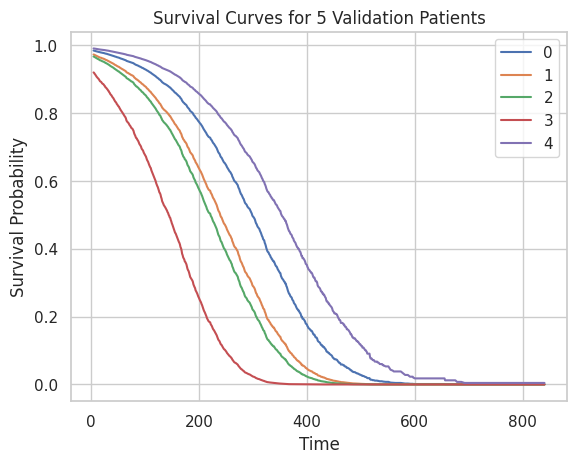

In [ ]:
model.compute_baseline_hazards()
surv = model.predict_surv_df(x_val_tensor)

# Plot a few survival curves
import matplotlib.pyplot as plt
surv.iloc[:, :5].plot()
plt.title("Survival Curves for 5 Validation Patients")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


# SHAP via surrogate model

DeepSurv is a neural net — SHAP doesn't natively support survival models with Cox loss.
So we'll:

Use DeepSurv to predict risk scores (or linear predictor)

Train a surrogate XGBoost model to approximate those predictions

Use SHAP on the surrogate model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val_dummy, y_train_dummy, y_val_dummy = train_test_split(
    X_scaled, y_time, test_size=0.2, random_state=42
)

# risk predictions on X_train_tensor
deep_risks = model.predict(x_train_tensor).detach().numpy().flatten()

# for surrogate model training
X_sur, X_sur_val, y_sur, y_sur_val = train_test_split(
    X_train, deep_risks, test_size=0.2, random_state=42
)


In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

In [ ]:
# Training XGB
surrogate_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
surrogate_model.fit(X_sur, y_sur)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

# SHAP Feature Importance



In [ ]:
import shap

# Initialize SHAP
explainer = shap.Explainer(surrogate_model)

# Compute SHAP values
shap_values = explainer(X_sur_val)


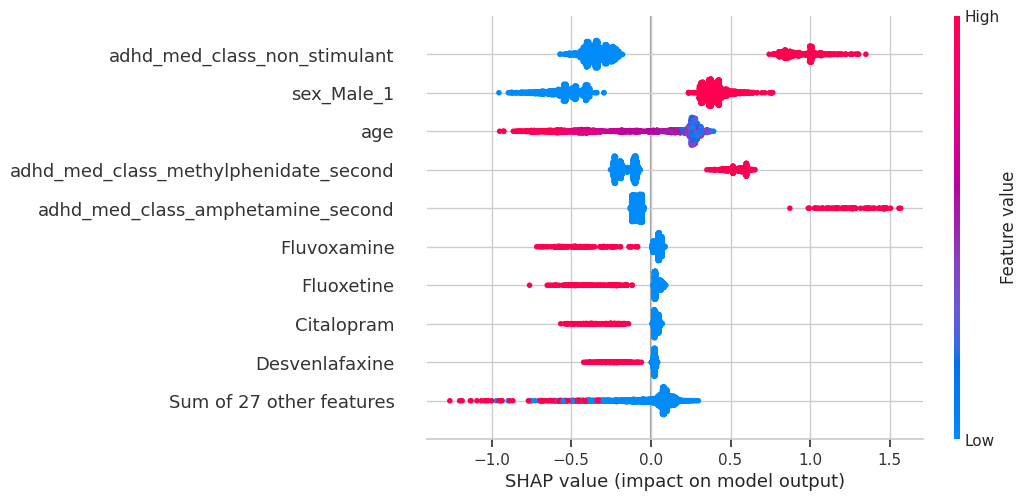

In [ ]:
X_sur_val_df = pd.DataFrame(X_sur_val, columns=X.columns)
shap_values = explainer(X_sur_val_df)
shap.plots.beeswarm(shap_values)


Interpretation of Top Features:
adhd_med_class_non_stimulant

Red (value=1): High SHAP value — taking non-stimulant ADHD meds increases the predicted outcome.

Blue (value=0): Low SHAP — not taking it pushes prediction down.

One of the most influential features.

- sex_Male_1

Males (red) tend to increase the outcome (positive SHAP values).

Females (blue) decrease it.

- age

Mixed effect: High values (older) are slightly positive; low values (younger) can decrease the prediction.

Purple indicates values are centered.

- adhd_med_class_methylphenidate_second

Red dots (likely those who received methylphenidate as a second med) increase predicted duration on first med.

Blue dots decrease it — not receiving it leads to shorter duration.

- adhd_med_class_amphetamine_second

Similar to above — receiving amphetamines secondarily (red) pushes prediction up.

- Other medications (Fluoxetine, Paroxetine, etc.):

Mostly binary (on/off). When taken (red), may slightly increase prediction, but individual effect is smaller.

Sum of 27 other features

Combined effect of less important features.

Generally negative SHAP values → collectively reduce predicted time on med.

**MOral of the story is :**
Model is most influenced by type of ADHD medication (especially non-stimulants), sex, and age.

Being male, older, or on non-stimulant meds correlates with longer time on first medication.

Secondary medications like methylphenidate or amphetamine have notable upward effects if used.

# before- when SES wwas not introduced

Color: Feature value (red = high cahnces of switching the med, blue = low chances - means they will stay on the first med for longer duration)

- Females (blue) lower hazard → stay longer on first med
- age Confirms the simulated assumption that age ≥ 40 leads to longer duration. Young peoplr tends to change, than the older ones
- adhd_med_class_non_stimulant-  higher hazard (early switch)
- SSRIs (Citalopram, Fluvoxamine, Sertraline, Paroxetine):
Red values (taking these meds) are mostly on the left side - reduce hazard. these extend time on first med, which is exactly what we intended

- Other ADHD meds:
methylphenidate_first, amphetamine_second also contribute somewhat
 Direction and impact size are reasonable compared to Cox model


Model is learning meaningful patterns — sex_Male, non_stimulant meds, SSRIs show strong directionality

#After - with SES


**Question was : Can the model identify that age/sex and depression medications reduce time on the first medication?**




**Model: DeepSurv neural network (2 hidden layers)**
Target: days_on_first_med
Event: switched_med

**Key Results**
- Concordance Index (C-index):

DeepSurv: 0.508

CoxPH: 0.54

While Cox performs slightly better overall, DeepSurv captures non-linear patterns.

- SHAP Analysis (via surrogate XGBoost model):

Top predictive features:

- sex_Male: associated with higher switch risk

- adhd_med_class_non_stimulant: associated with earlier discontinuation

# Conclusion:
Older age, female sex, and certain depression medications lead to longer time on the first ADHD medication.

--------------------------------------------------------------------------------------------------------


# STep 3: introduce interactions.


Re-load final dataset

Addind interaction effects like:

age * sex

non_stimulant + depression meds

female + SSRI = increased duration

And store it as a new column (e.g., days_on_first_med_v2)

re-train DeepSurv on this column and compare SHAP.

In [ ]:
df = pd.read_csv("UTopian_data.csv")

# Add interaction-based logic to simulate improved survival times
def add_interactions(df):
    np.random.seed(42)
    new_days = []

    for i, row in df.iterrows():
        base_days = np.random.lognormal(mean=6, sigma=0.5)
        base_days = np.clip(base_days, 150, 1460)

        # 1: Older males have shorter survival
        if row['age'] > 40 and row['sex_Male'] == 1:
            base_days -= 50

        # 2-Females on SSRIs have longer survival
        ssri_meds = ['Fluvoxamine', 'Sertraline', 'Escitalopram', 'Duloxetine']
        if row['sex_Male'] == 0 and any(row.get(med, 0) == 1 for med in ssri_meds):
            base_days += 40

        # 3- Non-stimulant + SSRI combo = higher switch risk
        if row['adhd_med_class'] == 'non_stimulant' and any(row.get(med, 0) == 1 for med in ssri_meds):
            base_days -= 30

        new_days.append(int(max(5, base_days)))

    df['days_on_first_med_interactions'] = new_days
    return df
df_interactions= add_interactions(df)
df_interactions.to_csv("UTopian_data_with_interactions.csv", index=False)
print("Updated dataset saved as 'UTopian_data_with_interactions.csv'")


Updated dataset saved as 'UTopian_data_with_interactions.csv'


In [ ]:
df_interactions.head()


,patient_id,age,postal_code,SES,Lisdexamfetamine,Dexamfetamine,Vyvanse,Amphetamine,Adderall,Dextroamphetamine,...,Asenapine,Cariprazine,has_anxiety_depression,has_odd,has_tourette,has_bipolar,sex_Male,switched_med,days_on_first_med,days_on_first_med_interactions
0,YBA4O1,28,P1A,High,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,329,517
1,27KCIG,31,P3E,Medium,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,24,376
2,SG8KAF,27,L1T,Low,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,52,557
3,20Z8MB,20,L1T,Medium,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,210,863
4,M28XO0,23,N6A,High,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,203,358


In [ ]:
df_interactions.dtypes

,0
patient_id,object
age,int64
postal_code,object
SES,object
Lisdexamfetamine,int64
Dexamfetamine,int64
Vyvanse,int64
Amphetamine,int64
Adderall,int64
Dextroamphetamine,int64


V2 -- denotes the interactions wala dataset

In [ ]:
df_interactions = pd.read_csv("UTopian_data_with_interactions.csv")

# Drop
drop_cols = ['patient_id', 'postal_code','SES'] + [
    'Lisdexamfetamine', 'Dexamfetamine', 'Vyvanse', 'Amphetamine', 'Adderall',
    'Dextroamphetamine', 'Dexedrine', 'Methylphenidate', 'Biphentin', 'Concerta',
    'FOQUEST', 'Ritalin', 'Atomoxetine', 'Strattera', 'Guanfacine', 'Intuniv'
]
df_interactions = df_interactions.drop(columns=drop_cols)
df_interactions = pd.get_dummies(df_interactions, columns=['sex_Male', 'adhd_med_class'], drop_first=True)

X_v2 = df_interactions.drop(columns=['days_on_first_med', 'switched_med', 'days_on_first_med_interactions'])
y_time_v2 = df_interactions['days_on_first_med_interactions'].values
y_event_v2 = df_interactions['switched_med'].values

scaler = StandardScaler()
X_scaled_v2 = scaler.fit_transform(X_v2)

x_train_v2, x_val_v2, y_time_train_v2, y_time_val_v2, y_event_train_v2, y_event_val_v2 = train_test_split(
    X_scaled_v2, y_time_v2, y_event_v2, test_size=0.2, random_state=42
)


In [ ]:
x_train_tensor_v2 = torch.tensor(x_train_v2, dtype=torch.float32)
x_val_tensor_v2 = torch.tensor(x_val_v2, dtype=torch.float32)
y_train_tuple_v2 = (
    torch.tensor(y_time_train_v2, dtype=torch.float32),
    torch.tensor(y_event_train_v2, dtype=torch.float32)
)
y_val_tuple_v2 = (
    torch.tensor(y_time_val_v2, dtype=torch.float32),
    torch.tensor(y_event_val_v2, dtype=torch.float32)
)


net_v2 = torch.nn.Sequential(
    torch.nn.Linear(x_train_v2.shape[1], 64),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(64),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(32, 1)
)

model_v2 = CoxPH(net_v2, tt.optim.Adam)
model_v2.optimizer.set_lr(0.001)

log_v2 = model_v2.fit(x_train_tensor_v2, y_train_tuple_v2, batch_size=256, epochs=100,
                      val_data=(x_val_tensor_v2, y_val_tuple_v2), verbose=True)


0:	[0s / 0s],		train_loss: 4.6416,	val_loss: 7.0244
1:	[0s / 0s],		train_loss: 4.5868,	val_loss: 7.0170
2:	[0s / 0s],		train_loss: 4.5651,	val_loss: 7.0191
3:	[0s / 0s],		train_loss: 4.5366,	val_loss: 7.0182
4:	[0s / 1s],		train_loss: 4.5343,	val_loss: 7.0183
5:	[0s / 1s],		train_loss: 4.5267,	val_loss: 7.0226
6:	[0s / 1s],		train_loss: 4.5274,	val_loss: 7.0194
7:	[0s / 1s],		train_loss: 4.5227,	val_loss: 7.0226
8:	[0s / 2s],		train_loss: 4.5235,	val_loss: 7.0253
9:	[0s / 2s],		train_loss: 4.5177,	val_loss: 7.0256
10:	[0s / 2s],		train_loss: 4.5195,	val_loss: 7.0261
11:	[0s / 2s],		train_loss: 4.5114,	val_loss: 7.0234
12:	[0s / 2s],		train_loss: 4.5136,	val_loss: 7.0275
13:	[0s / 3s],		train_loss: 4.5102,	val_loss: 7.0282
14:	[0s / 3s],		train_loss: 4.5097,	val_loss: 7.0292
15:	[0s / 3s],		train_loss: 4.5061,	val_loss: 7.0309
16:	[0s / 3s],		train_loss: 4.4972,	val_loss: 7.0351
17:	[0s / 3s],		train_loss: 4.5022,	val_loss: 7.0355
18:	[0s / 4s],		train_loss: 4.5001,	val_loss: 7.0382
19:

In [ ]:
model_v2.compute_baseline_hazards()

from pycox.evaluation import EvalSurv
surv_v2 = model_v2.predict_surv_df(x_val_tensor_v2)
ev_v2 = EvalSurv(surv_v2, y_val_tuple_v2[0].numpy(), y_val_tuple_v2[1].numpy(), censor_surv='km')
c_index_v2 = ev_v2.concordance_td('antolini')
print(f"Concordance Index (DeepSurv v2 with interactions): {c_index_v2:.3f}")


Concordance Index (DeepSurv v2 with interactions): 0.506


Almost same as before → suggests model is stable but didn’t gain much extra from new interactions